# Сборный проект

## Описание проекта

Перед нами набор данных из открытого источника Министерства Культуры: 
- набор данных, хранящий информацию о фильмах;
- набор данных, хранящий информацию о сборах.

### Цель проекта

Целью проекта является исследование рынка киноиндустрии, его главных трендов и особенностей.

**План исследования:**
- [Изучение данных;](#explore) 
- [Предоработка данных;](#prepare) 
- [Исследовательский анализ;](#research) 
- [Выводы.](#conclus) 

Исследование разделено на следущие блоки:
- Посмотрим, [сколько фильмов выходило в прокат каждый год](#count_film) и посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.
- Изучим [динамику проката](#dynamic) по годам. В каком году сумма сборов была минимальной? А максимальной?.
- Определим, как влияет [возрастное ограничение аудитории](#age) («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате.
- Исследование фильмов, [получивших господдержку](#support), где мы проведем анализ фильмов, сравним величину госфинансирования, общий бюджет и окупаемость таких фильмов. А так же посмотрим на топы коммерчески успешных и неудачных проектов.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

import re

pd.options.display.float_format = '{:,.2f}'.format

## Изучение данных: <a id='explore'></a>

В нашем распоряжении 2 набора данных: с информацией о фильмах и информацией о прокате, оба в формате csv. Сохраним их в переменные для дальнейшего изучения:

In [2]:
try:
    df_mov = pd.read_csv('mkrf_movies.csv')
    df_show = pd.read_csv('mkrf_shows.csv')
except:
    df_mov = pd.read_csv('/datasets/mkrf_movies.csv')
    df_show = pd.read_csv('/datasets/mkrf_shows.csv')
finally:
    display(df_mov.sample(5))
    display(df_show.sample(5))

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
2785,Москва никогда не спит,111010615,2015-06-15T12:00:00.000Z,Художественный,"ООО ""СНАПШОТ ФИЛМЗ ВОСТОК"", Блайндер Филмз Лтд...",Россия-Ирландия,Джонни О'Райлли,Джонни О'Райлли,«16+» - для детей старше 16 лет,nan,nan,nan,NaN,5.5,"драма,комедия,триллер"
2896,"Громче, чем бомбы",121007516,2016-04-01T12:00:00.000Z,Художественный,"Мотлис, Энимал Кингдом, Арт Франс Синема, Бичс...",Франция - США - Норвегия - Дания,Йоаким Триер,"Джошуа Астрачан, , Альберт Бергер, Рон Йеркса,...",«18+» - запрещено для детей,nan,nan,nan,NaN,6.5,драма
2886,Первый мститель: Противостояние,121010316,2016-04-28T12:00:00.000Z,Художественный,"Марвел Интертейнмент, Марвел Студиос",США,"Джо Руссо, Энтони Руссо",Кевин Фейги,«16+» - для детей старше 16 лет,nan,nan,nan,NaN,7.4,"фантастика,боевик,приключения"
1590,Теорема Zero,121011914,2014-06-11T12:00:00.000Z,Художественный,"Волтаж Пикчерз, Занук Индепендент, МедиаПро Пи...",США - Румыния - Великобритания,Тьерри Гиллиам,"Дин Занук, Николас Картье",«16+» - для детей старше 16 лет,nan,nan,nan,NaN,6.5,"фантастика,триллер,драма"
4724,Подарок-,114001410,2010-12-24T12:00:00.000Z,Анимационный,"ООО ""Студия ""А-фильм""",Россия,М.Дворянкин,В.Хижнякова,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,6.4,"триллер,драма,детектив"


,puNumber,box_office
143,111003011,"50,200.00"
1374,121009214,"1,950.00"
192,111004313,"2,100.00"
709,111019515,"129,333.50"
2246,121025918,"1,689,958.00"


Для начала изучим данных в таблице с фильмами:

In [3]:
df_mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
title                    7486 non-null object
puNumber                 7486 non-null object
show_start_date          7486 non-null object
type                     7486 non-null object
film_studio              7468 non-null object
production_country       7484 non-null object
director                 7477 non-null object
producer                 6918 non-null object
age_restriction          7486 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  6519 non-null object
genres                   6510 non-null object
dtypes: float64(3), object(12)
memory usage: 877.4+ KB


Мы видим следующие колонки:
- title — название фильма (нет пропусков);
- puNumber — номер прокатного удостоверения (нет пропусков - перевести в целочисленный?);
- show_start_date — дата премьеры фильма (нет пропусков - перевести в дату);
- type — тип фильма (нет пропусков);
- film_studio — студия-производитель (18 пропусков);
- production_country — страна-производитель (нет пропусков);
- director — режиссёр (9 пропусков);
- producer — продюсер (568 пропусков);
- age_restriction — возрастная категория (нет пропусков);
- refundable_support — объём возвратных средств государственной поддержки (7154 пропусков - заполнены только для тех фильмов, у которых есть гос поддержка. Пропуск означает отсутствие гос поддержки);
- nonrefundable_support — объём невозвратных средств государственной поддержки (7154 пропусков - заполнены только для тех фильмов, у которых есть гос поддержка. Пропуск означает отсутствие гос поддержки);
- financing_source — источник государственного финансирования (7154 пропусков - заполнены только для тех фильмов, у которых есть гос поддержка. Пропуск означает отсутствие гос поддержки);
- budget — общий бюджет фильма (7154 пропусков - заполнены только для тех фильмов, у которых есть гос поддержка. Пропуск означает отсутствие гос поддержки);
- ratings — рейтинг фильма на КиноПоиске (967 пропусков - примерно 13%);
- genres — жанр фильма (976 пропусков - примерно 13%).

Надо будет изучить, являются ли пропуски в колонках ratings и genres пересекающимися. 

Таблица с прокатом значительно проще:

In [4]:
df_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
puNumber      3158 non-null int64
box_office    3158 non-null float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Всего 2 колонки, без пропусков, с 3158 строками:
- puNumber — номер прокатного удостоверения;
- box_office — сборы в рублях.

Сразу можно видеть, что данные по сборам есть далеко не для всех фильмов.


Создадим функцию, которая будет выдавать сразу всю необходимую информацию о таблице:

In [5]:
def inform_func(dataframe):
    
    '''Выдает информацию по таблице в аргументе: info() и describe()'''
    display(dataframe.info())
    display(dataframe.describe(include='all').T)
    display(dataframe.sample(5))

## Предоработка данных <a id='prepare'></a>

Переведем колонку show_start_date в формат даты:

In [6]:
df_mov['show_start_date'] = pd.to_datetime(df_mov['show_start_date'], format='%Y-%m-%dT%H:%M:%S')

Колонка puNumber - числовая, ее можно перевести в целочисленный вид для оптимизации. Но при переводе выпадает ошибка, обработаем ее:

In [7]:
try:
    df_mov['puNumber'] = df_mov['puNumber'].astype('int')
except ValueError as ve:
    print(ve)

invalid literal for int() with base 10: 'нет'


Мы видим, что в колонке есть недопустимое значение "нет" для перевода в целочисленный вид. Это буквенное сочетание и, возможно, не единичное. Проверим сразу все строки на содержание букв:

In [8]:
# Воспользуемся методом str.isalpha(), который выдает True, если в стоке содержатся только буквы:

df_mov[df_mov['puNumber'].str.isalpha()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,Курбан-роман. (История с жертвой),нет,2014-05-15 12:00:00+00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,NaN,NaN


Значение "нет" все же встречается только 1 раз, других буквенных значений в колонке нет, тогда уберем эту строку из набора данных:

In [9]:
df_mov = df_mov[~df_mov['puNumber'].str.isalpha()]

Теперь не должно быть ошибок. Переведем сразу в обоих наших таблицах данную колонку в целочисленный тип:

In [10]:
try:
    df_mov['puNumber'] = df_mov['puNumber'].astype('int')
    df_show['puNumber'] = df_show['puNumber'].astype('int')
except ValueError as ve:
    print(ve)

Объединим данные по двум таблицам в одну:

In [11]:
# воспользуемся методом merge(), выполнять будем "левое" соединения, 
# чтобы сохранить данные о фильмах, даже если их нет в прокате

df = df_mov.merge(df_show, on='puNumber', how='left')

inform_func(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
title                    7485 non-null object
puNumber                 7485 non-null int64
show_start_date          7485 non-null datetime64[ns, UTC]
type                     7485 non-null object
film_studio              7467 non-null object
production_country       7483 non-null object
director                 7476 non-null object
producer                 6917 non-null object
age_restriction          7485 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  6519 non-null object
genres                   6510 non-null object
box_office               3158 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(10)
memory usage: 994.1+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
title,7485,6771,День святого Валентина_,5,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,"7,485.00",NaN,NaN,NaN,NaT,NaT,"135,196,587.56","38,352,919.34","1,811,096.00","112,025,118.00","121,015,510.00","124,003,314.00","231,001,111.00"
show_start_date,7485,1964,2010-12-17 12:00:00+00:00,96,2010-01-11 12:00:00+00:00,2019-12-30 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7485,8,Художественный,4519,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,7467,5490,"Киностудия ""Мосфильм""",341,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,7483,950,США,2172,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,7476,4811,О.Семёнова,47,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,6917,5349,П.Смирнов,67,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_restriction,7485,5,«16+» - для детей старше 16 лет,2851,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
refundable_support,332.00,NaN,NaN,NaN,NaT,NaT,"11,864,457.83","24,916,555.26",0.00,0.00,0.00,"15,000,000.00","180,000,000.00"


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
890,Жизнь.,121018112,2012-07-24 12:00:00+00:00,Художественный,"Би-Би-Си, Ай Эм Глобал, Магик Лайт Пикчерз",Великобритания,"Майкл Гантон, Марта Холмс","Маркус Артур, Мартин Поуп, Майкл Роуз",«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,6.6,"драма,мелодрама","1,680.00"
1681,Сердце льва,121006114,2014-04-03 12:00:00+00:00,Художественный,"Филм и Васт, Хельсинки Филми Ой, Суомен Элокюв...",Финляндия,Доме Карукоски,Алекси Барды,«18+» - запрещено для детей,nan,nan,nan,NaN,7.1,"драма,мелодрама",nan
5746,Мэри и ведьмин цветок,124000718,2018-03-01 12:00:00+00:00,Анимационный,Панок,Япония,Хиромаса Ёнэбаяси,"Ёсиаки Нисимура, Джеффри Уэкслер",«6+» - для детей старше 6 лет,nan,nan,nan,NaN,7.0,"аниме,мультфильм,приключения","87,194,421.31"
1609,Фрэнк.,121009814,2014-05-27 12:00:00+00:00,Художественный,"Ранэвэй Фридж Продакшнз, Элемент Пикчерз, Филм...",Великобритания - Ирландия,Ленни Абрахамсон,"Дэвид Баррон, Эд Гини, Стиви Ли",«16+» - для детей старше 16 лет,nan,nan,nan,NaN,7.0,"драма,комедия",nan
1928,Каникулы маленького Николя,121025614,2014-11-06 12:00:00+00:00,Художественный,"Фиделите Филмс, М6 Филмс, Канал+",Франция,Лоран Тирар,"Оливье Дебоск, Марк Миссонье",«6+» - для детей старше 6 лет,nan,nan,nan,NaN,6.7,"комедия,семейный","14,800.00"


Проверим пропуски в колонке production_country - их всего 2 штуки, возможно, и легко заполнить:

In [12]:
df[df['production_country'].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3185,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,7.2,"детский,комедия","194,527.00"
4440,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,4.0,"мультфильм,комедия",nan


Да, это кинофильмы российского производства. Конечно, можно было бы и удалить эти строчки, так как их всего 2, но что удаление, что заполнение - одна строка кода:

In [13]:
df['production_country'] = df['production_country'].fillna('Россия')

Проверим категориальные данные на содержание:

In [14]:
# Реализуем это с помощью цикла:

for column in ['type', 'production_country', 'title']:
    print(column)
    print(list(df[column].unique())) # Выводим список уникальных значений
    print(len(df[column].unique())) # Выводим количество уникальных значений

type
['Художественный', 'Анимационный', 'Прочие', 'Документальный', 'Научно-популярный', ' Художественный', ' Анимационный', 'Музыкально-развлекательный']
8
production_country
['США', 'СССР', 'Франция', 'СССР, Венгрия', 'Германия-Великобритания', 'Великобритания - Италия', 'Чехословакия', 'США - Франция - Турция', 'Новая Зеландия', 'Канада - Франция - Испания', 'США-Германия', 'США - Великобритания', 'Великобритания', 'США - Германия', 'Франция - Мексика - США', 'Россия, Казахстан, США', 'СССР, Швеция', 'СССР, Франция, Англия, Куба, ГДР', 'Германия', 'Великобритания-США-Германия-КНР', 'СССР, ЧССР, Западный Берлин, ПНР', 'СССР, Италия', 'Гонконг, КНР', 'США - Франция', 'США - Япония - Франция - Великобритания', 'Гонконг - Сингапур - Таиланд - Великобритания', 'США-Канада', 'Франция - Италия - Великобритания - США', 'Франция - США', 'Ирландия-Великобритания-Германия', 'Чехия', 'США-Австралия', 'СССР, Финляндия', 'США-Франция-Великобритания-Австрия', 'США - Бельгия', 'США - Ирландия - Вел

Списки получились внушительные, но, можно выделить главное:
- для `type`: убираем пробел перед ' Художественный', ' Анимационный';
- для `production_country`: можно унифицировать тип записи, убрав пробелы (тогда разделение между странами останется только запятыми или дефизами), и заменив запятые и дефизы на сочетание запятой с пробелом;
- для `title` характерны мусорные знаки в конце: нижние подчеркивания и точки - уберем их.

In [15]:
# Уберем с помощью метода str.rstrip() в конце (справа) различные мусорные знаки:
df['title'] = df['title'].str.rstrip('._- \n\t')

# Уберем лишние пробелы:
df['type'] = df['type'].str.strip()

# Напишем лямбда-функцию по замене знаков препинания при перечислении стран и применим ее к колонке методом apply():
df['production_country'] = df['production_country'].apply(
    lambda x: x.replace(' ', '').replace('-', ', ').replace(',', ', '))

Посмотрим, как сократилось количество уникальных элементов в колонках:

In [16]:
for column in ['type', 'production_country', 'title']:
    print(column)
    print(len(df[column].unique()))

type
6
production_country
858
title
6670


Главное - типы. Остальное не так значимо, но все-таки немного унифицировалось (да и в принципе смотреться будет красивее при выводе на экран). Это может помочь в дальнейшем.

Рассмотрим пропуски в колонке `ratings`:

In [17]:
inform_func(df[df['ratings'].isna()])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 43 to 7483
Data columns (total 16 columns):
title                    966 non-null object
puNumber                 966 non-null int64
show_start_date          966 non-null datetime64[ns, UTC]
type                     966 non-null object
film_studio              953 non-null object
production_country       966 non-null object
director                 960 non-null object
producer                 876 non-null object
age_restriction          966 non-null object
refundable_support       16 non-null float64
nonrefundable_support    16 non-null float64
budget                   16 non-null float64
financing_source         16 non-null object
ratings                  0 non-null object
genres                   0 non-null object
box_office               244 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(10)
memory usage: 128.3+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
title,966,956,Три сестры,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,966.00,NaN,NaN,NaN,NaT,NaT,"121,888,904.63","21,919,067.87","111,000,219.00","112,000,518.25","114,003,817.50","126,000,286.50","224,020,710.00"
show_start_date,966,664,2018-08-01 12:00:00+00:00,8,2010-01-15 12:00:00+00:00,2019-12-30 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,966,5,Художественный,368,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,953,672,"ООО ""Мульт в кино""",46,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,966,122,Россия,524,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,960,796,О.Семёнова,38,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,876,670,П.Смирнов,56,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_restriction,966,5,«0+» - для любой зрительской аудитории,343,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
refundable_support,16.00,NaN,NaN,NaN,NaT,NaT,"4,375,000.00","9,464,847.24",0.00,0.00,0.00,0.00,"25,000,000.00"


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1679,Рихард Вагнер. Парсифаль /По одноименному прои...,126005313,2013-12-27 12:00:00+00:00,Прочие,Артс Альянс Медиа,Великобритания,Стивен Лангридж,"Ройал Опера Хаус, Артс Альянс Медиа",«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,NaN,NaN,nan
2126,Свой почерк (Альманах из 6-ти короткометражных...,111002315,2015-03-05 12:00:00+00:00,Художественный,"ООО ""Продюсерская фирма Игоря Толстунова""",Россия,"Н.Сутырин, М.Кулунаков, А.Бильжо, А.Першин, И....",И.Толстунов и др.,«18+» - запрещено для детей,nan,nan,nan,NaN,NaN,NaN,nan
6242,МУЛЬТ в кино. Выпуск № 81,114006118,2018-09-29 12:00:00+00:00,Анимационный,"ООО ""Мульт в кино""",Россия,О.Семёнова,П.Смирнов,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,NaN,NaN,nan
6667,ИСТОРИКИ ОБ ИСТОРИИ или СЛОВО О ПОЛЕ КУЛИКОВОМ,112001419,2019-02-28 12:00:00+00:00,Документальный,"ООО ""Киностудия ""Гранат""",Россия,А.Бадягина,"Е.Резников, В.Сидашов",«6+» - для детей старше 6 лет,nan,nan,nan,NaN,NaN,NaN,nan
6144,Апостол Камчатки,112006218,2018-08-21 12:00:00+00:00,Документальный,"ООО ""ЛВ ФИЛЬМ""",Россия,"В.Хохлов, К.Ляшенко",Ю.Бабаханов,«6+» - для детей старше 6 лет,nan,nan,nan,NaN,NaN,NaN,nan


Видим, что там, где отсутствуют рейтинг, там отсутствует и указание жанра. Судя по данным, это в основном российские фильмы, на треть ориентированные на детскую аудиторию. Мы знаем, что рейтинг тянется с сайта КиноПоиск. Возможно, эти данные взаимосвязаны. Если жанр определить проблематично, что рэйтинг можно попробовать определить по медиане, группируя по стране, типу и возрастному органичению, например.

Для этого надо перевести колонку `ratings` в вещественный тип.  Сразу пропишем с обработкой ошибки:

In [18]:
try:
    df['ratings'] = pd.to_numeric(df['ratings'])
except ValueError as ve:
    print(ve)

Unable to parse string "99%" at position 259


Строка "99%" - не может быть переведена в вещественный тип. Посмотрим глазами на уникальные значения в колонке `ratings`:

In [19]:
df['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

Уникальные значений получилось не так много, можно оценить взглядом, что проблемы 2: числа, выраженные в процентах, и пропуски.

Сначала соберем в отдельные список значения с процентом, чтобы посмотреть, какие фильмы там оказались:

In [20]:
list_ind = []
for i in df['ratings'].unique():
    try:
        if '%' in i:
            list_ind.append(i)
    except:                              # тут может выскочить ошибка при обработке пропусков, поэтому отработаем ее
        pass
    

print(list_ind)

['99%', '28%', '97%', '83%', '64%', '91%', '94%', '62%', '79%', '90%', '19%', '88%', '89%', '98%']


Теперь этот список мы можем поместить в фильтрующий метод isin(), чтобы изучиться, сколько и какие фильмы попали в выборку:

In [21]:
inform_func(df[df['ratings'].isin(list_ind)])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 259 to 7276
Data columns (total 16 columns):
title                    29 non-null object
puNumber                 29 non-null int64
show_start_date          29 non-null datetime64[ns, UTC]
type                     29 non-null object
film_studio              29 non-null object
production_country       29 non-null object
director                 29 non-null object
producer                 29 non-null object
age_restriction          29 non-null object
refundable_support       2 non-null float64
nonrefundable_support    2 non-null float64
budget                   2 non-null float64
financing_source         2 non-null object
ratings                  29 non-null object
genres                   26 non-null object
box_office               15 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(10)
memory usage: 3.9+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
title,29,28,Добыча,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,29.00,NaN,NaN,NaN,NaT,NaT,"122,355,777.72","26,624,228.31","111,001,014.00","111,012,715.00","112,003,719.00","121,009,411.00","221,030,715.00"
show_start_date,29,29,2012-11-29 12:00:00+00:00,1,2010-09-03 12:00:00+00:00,2019-10-23 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,29,4,Художественный,22,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,29,29,"ЗАО ""Киностудия ""М""-Фильм""",1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,29,11,Россия,17,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,29,28,Ю.Грымов,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,29,29,"Эктор Бабенко, Оскар Крамер, Хуго Сидмэн",1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_restriction,29,5,«16+» - для детей старше 16 лет,8,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
refundable_support,2.00,NaN,NaN,NaN,NaT,NaT,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3584,"Машины Страшилки. Серия ""Жутчайшая повесть о п...",114003916,2016-12-09 12:00:00+00:00,Анимационный,"ООО Студия ""АНИМАККОРД"", АНИМАККОРД ЛТД.","Россия, РеспубликаКипр",Д.Червяцов,"Д.Ловейко, О.Кузовков",«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,97%,"мультфильм,ужасы,фэнтези",nan
259,Прошлое,221030715,2015-07-29 12:00:00+00:00,Художественный,"20 Сенчюри Фокс де Архентина, Чемо, ЭйчБи Филм...","Аргентина, Бразилия",Эктор Бабенко,"Эктор Бабенко, Оскар Крамер, Хуго Сидмэн",«16+» - для детей старше 16 лет,nan,nan,nan,NaN,99%,"ужасы,триллер,драма",nan
7276,Добыча,121028319,2019-10-03 12:00:00+00:00,Художественный,"Блумхаус Продакшнз, Хайд Парк Интертейнмент, Т...",США,Франк Халфун,"Ашок Амритрадж, Джейсон Блум, Трэвис Клафф",«16+» - для детей старше 16 лет,nan,nan,nan,NaN,88%,"фантастика,боевик,триллер","4,416,590.45"
3445,Короткие истории о любви - 4,126006316,2016-12-30 12:00:00+00:00,Прочие,"Нетворг Айлэнд Телевижн, Магнетфильм, Шорткатс...","Великобритания, Аргентина, США, Франция, Р...","Д.Адар, П.Антохин, М.Биасин, А.Бурунова, К.Кол...","Д.Адар, Д.Амсон, П.Антохин, А.Армстронг, С.Бил...",«18+» - запрещено для детей,nan,nan,nan,NaN,83%,NaN,"2,266,408.00"
3438,Семь диких историй,126005916,2016-11-28 12:00:00+00:00,Прочие,"Макс Бэйкер, Джон Е.Брайан, Пьер-Луи Гарнон, ...","США, Пуэрто, Рико, Франция","М.Бэйкер, Д.Е.Брайант, Д.Рондот, Я.Серсар, Д.С...","М.Бэйкер, Д.Е.Брайан, П.-Л.Гарнон, М.Х.Дельгад...",«18+» - запрещено для детей,nan,nan,nan,NaN,88%,NaN,"1,025,937.00"


Можно было бы подумать, что эти проценты являются рейтингом оценки фильма, но, если открывать страницы данных кинопроизведений на сайте КиноПоиска, выяснясняется, что это не так. Скорее всего в данный столбец подтянулся рейтинг ожидаемости фильма, так как на этапе парсинга не хватало данных, чтобы выставить ему оценку по 10-бальной шкале. Можно добавить к данному фрейму пропуски по колонкам рейтинга и жанров и отправить отчет, чтобы выяснить, является ли это системной ошибкой или отсутствие данных для этих фильмов - норма.

In [22]:
# Формируем отдельную таблицу для отчета об ошибке:

df_debag = df[(df['ratings'].isin(list_ind)) | 
                  (df['ratings'].isna()) | 
                  (df['genres'].isna())
                 ]

inform_func(df_debag)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 43 to 7483
Data columns (total 16 columns):
title                    1001 non-null object
puNumber                 1001 non-null int64
show_start_date          1001 non-null datetime64[ns, UTC]
type                     1001 non-null object
film_studio              988 non-null object
production_country       1001 non-null object
director                 995 non-null object
producer                 911 non-null object
age_restriction          1001 non-null object
refundable_support       18 non-null float64
nonrefundable_support    18 non-null float64
budget                   18 non-null float64
financing_source         18 non-null object
ratings                  35 non-null object
genres                   26 non-null object
box_office               261 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(10)
memory usage: 132.9+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
title,1001,990,"Легион_.(Фильм содержит сцены ужасов, насилия ...",2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,"1,001.00",NaN,NaN,NaN,NaT,NaT,"121,847,207.72","22,001,700.30","111,000,219.00","112,000,210.00","114,003,716.00","126,000,212.00","224,020,710.00"
show_start_date,1001,685,2018-08-01 12:00:00+00:00,8,2010-01-15 12:00:00+00:00,2019-12-30 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,1001,5,Художественный,396,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,988,702,"ООО ""Мульт в кино""",46,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,1001,130,Россия,546,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,995,825,О.Семёнова,38,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,911,698,П.Смирнов,56,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_restriction,1001,5,«0+» - для любой зрительской аудитории,345,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
refundable_support,18.00,NaN,NaN,NaN,NaT,NaT,"3,888,888.89","9,002,541.40",0.00,0.00,0.00,0.00,"25,000,000.00"


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
5489,МУЛЬТ в кино. Выпуск № 58,114002217,2017-09-16 12:00:00+00:00,Анимационный,"ООО ""Мульт в кино""",Россия,О. Семёнова,П. Смирнов,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,NaN,NaN,nan
3143,Редкие птицы (2014),126003915,2015-12-29 12:00:00+00:00,Прочие,"Т.М.Райвс, Од Бист Филмз","США, Норвегия",Т.М.Райвс,Т.М.Райвс,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,NaN,NaN,nan
804,Паранормальный Якутск,111004112,2012-08-24 12:00:00+00:00,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,nan,nan,nan,NaN,NaN,NaN,nan
4630,Парфюмер: История одного убийцы (по роману Пат...,221153310,2010-12-17 12:00:00+00:00,Художественный,"Константин Филм, ВИР 4 Медиенфондс, Нувель Еди...","Франция, Испания, Германия",Том Тыквер,"Эндрю Биркин, Бернд Эйхенгер, Мартин Московиц",«16+» - для детей старше 16 лет,nan,nan,nan,NaN,NaN,NaN,nan
2528,Чёрная месса,121021415,2015-10-23 12:00:00+00:00,Художественный,"Уорнер Бразерс, Кросс Крик Пикчерз, Гризби Про...",США,Скотт Купер,"Джон Лешер, Брайан Оливер",«18+» - запрещено для детей,nan,nan,nan,NaN,NaN,NaN,"136,223,214.80"


Получился довольно внушительный список. Но нам надо продолжить исследование, поэтому устраним то, что возможно: переведем колонку в вещественный вид, заменяя оценки в процентах в на пропуски, которые после заменим медианным значением.

count   6,490.00
mean        6.48
std         1.10
min         1.00
25%         5.90
50%         6.60
75%         7.20
max         9.20
Name: ratings, dtype: float64

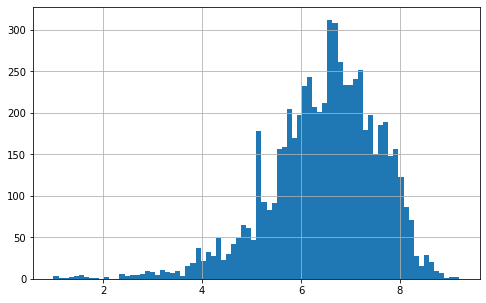

In [23]:
# Переведем колонку в вещественный тип, заменяя значения с % на NaN:
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

# Изучим так же вид распределения оценок:
display(df['ratings'].describe())
df['ratings'].hist(bins=df['ratings'].nunique(), figsize=(8,5))

По гистограмме видно, что данные распределены почти нормально, сильных выбросов нет, пределы в норме: от 1 до 9,2 (шкала у нас 10-бальная - нельзя поставить фильму меньше 1, а рейтинг выдается как среднее от всех оценок, поэтому целое число 10 - маловероятно).

Посмотрим как на средний рейтинг фильмов влияют тип, возрастное ограничение и страна производства фильмов:

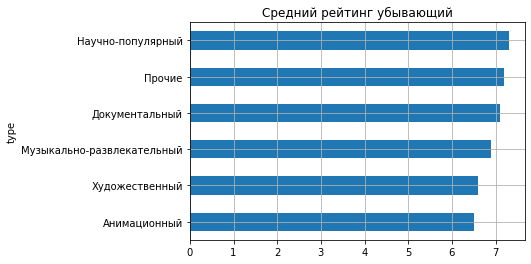

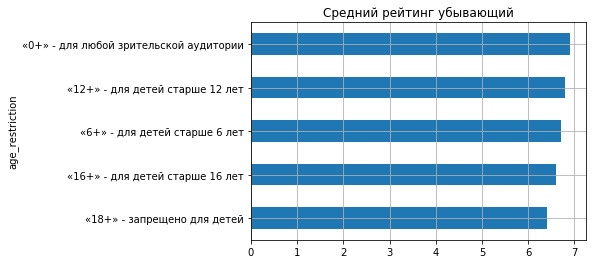

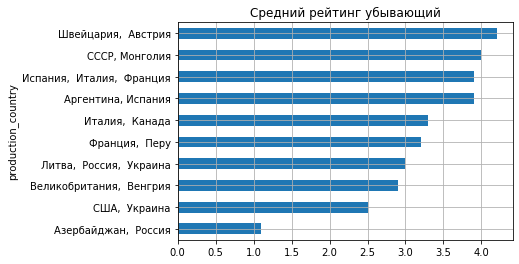

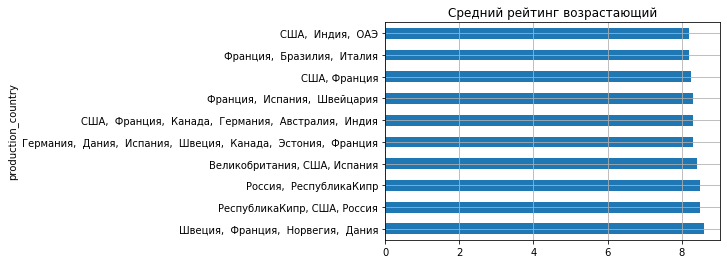

In [24]:
for column in ['type', 'age_restriction', 'production_country']:
    fig, ax = plt.subplots()
    (
        df.groupby(column)['ratings'].median().sort_values().head(10)
        .plot(kind='barh', ax=ax, grid=True)
    )
    ax.set(title='Средний рейтинг убывающий', ylabel=column)
    plt.show()

# Дострою здесь еще топ-10 стран с высоким рейтингом фильмов:    
fig, ax = plt.subplots()
(
    df.groupby('production_country')['ratings'].median().sort_values(ascending=False).head(10)
    .plot(kind='barh', grid=True)
)
ax.set(title='Средний рейтинг возрастающий', ylabel='production_country')
plt.show()

Конечно, построить график рейтинга всех стран проблематично, их в наборе данных 858 единиц, но мы вывели те, что в топе и те, что в конце рейтинга, но, возможно, количество фильмов по этим странам не так велико. Посмотрим, какие страны выпускают больше всего фильмов и на рейтинг в них:

In [25]:
# Построим сводную табличку по странам, посчитав для каждой количество фильмов и их медианный рейтинг:
df_agg = df.groupby('production_country').agg({'ratings':['count', 'median']}).reset_index()

# Переименуем колонки для удобства и избавления от мультииндексности:
df_agg.columns = ['production_country', 'count', 'median_rating']

# Сортируем по количеству стран и выведем только топ-15:
df_agg = df_agg.sort_values(by='count', ascending=False).head(15)
df_agg

,production_country,count,median_rating
523,США,2104,6.70
448,Россия,1281,6.30
502,СССР,361,7.20
708,Франция,290,6.40
60,Великобритания,192,6.60
536,"США, Великобритания",103,7.40
149,Германия,96,6.70
846,Япония,74,7.15
307,Италия,72,6.45
281,Испания,71,6.30


Больше всего фильмов выпускает США и их рейтинг близок к медианному, у российских фильмов чуть ниже. И так же видим, что колебания рейтингов не большие: 7,4 - 6,3. 

Заполним в этом случае пробелы в колонке `ratings`, группируя по типу, возрастному рейтингу и странам - такая группировка будет наиболее точной. Если останутся пробелы, в зависимости от их количества, решим дозаполнить их или удалить.

In [26]:
# Заполняем пропуски, используя метод transform():
df['ratings'] = df['ratings'].fillna(
    df.groupby(['type', 'production_country', 'age_restriction'])['ratings'].transform('median'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
title                    7485 non-null object
puNumber                 7485 non-null int64
show_start_date          7485 non-null datetime64[ns, UTC]
type                     7485 non-null object
film_studio              7467 non-null object
production_country       7485 non-null object
director                 7476 non-null object
producer                 6917 non-null object
age_restriction          7485 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  7363 non-null float64
genres                   6510 non-null object
box_office               3158 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(9)
memory usage: 1.3+ MB


In [27]:
df[df['ratings'].isna()].shape

(122, 16)

122 строк - это 1,6% от датафрейма. Удалим их.

In [28]:
df = df.dropna(subset=['ratings']).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7363 entries, 0 to 7362
Data columns (total 17 columns):
index                    7363 non-null int64
title                    7363 non-null object
puNumber                 7363 non-null int64
show_start_date          7363 non-null datetime64[ns, UTC]
type                     7363 non-null object
film_studio              7345 non-null object
production_country       7363 non-null object
director                 7354 non-null object
producer                 6807 non-null object
age_restriction          7363 non-null object
refundable_support       331 non-null float64
nonrefundable_support    331 non-null float64
budget                   331 non-null float64
financing_source         331 non-null object
ratings                  7363 non-null float64
genres                   6507 non-null object
box_office               3094 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(9)
memory usage: 978.0+ KB


Изучим пропуски в колонке `director`

In [29]:
inform_func(df[df['director'].isna()])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 761 to 4866
Data columns (total 17 columns):
index                    9 non-null int64
title                    9 non-null object
puNumber                 9 non-null int64
show_start_date          9 non-null datetime64[ns, UTC]
type                     9 non-null object
film_studio              8 non-null object
production_country       9 non-null object
director                 0 non-null object
producer                 5 non-null object
age_restriction          9 non-null object
refundable_support       0 non-null float64
nonrefundable_support    0 non-null float64
budget                   0 non-null float64
financing_source         0 non-null object
ratings                  9 non-null float64
genres                   3 non-null object
box_office               1 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(9)
memory usage: 1.3+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
index,9.00,NaN,NaN,NaN,NaT,NaT,"3,711.44","1,460.73",764.00,"3,839.00","4,297.00","4,440.00","4,941.00"
title,9,9,Георг Фридрих Гендель. Мессия. Оратория. Корол...,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,9.00,NaN,NaN,NaN,NaT,NaT,"166,119,755.22","47,582,215.79","126,001,111.00","126,002,711.00","126,003,512.00","217,017,310.00","217,027,010.00"
show_start_date,9,9,2010-11-11 12:00:00+00:00,1,2010-01-25 12:00:00+00:00,2013-09-11 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,9,2,Прочие,5,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,8,7,"ООО ""Барс Рекордс""",2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,9,3,Россия,4,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,0,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,5,5,Британский музей,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_restriction,9,2,«0+» - для любой зрительской аудитории,7,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4847,4922,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00+00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,7.30,NaN,nan
4225,4297,Изге Вэли (Святой Валентин),217020610,2010-05-20 12:00:00+00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,6.20,NaN,nan
3980,4051,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 12:00:00+00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,6.70,NaN,nan
1719,1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00+00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,7.30,NaN,nan
3769,3839,Зур концерт (Большой концерт),217027010,2010-06-24 12:00:00+00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,6.20,NaN,nan


Всего 9 значений, проверять, кто является режиссером картин долго, процент данных не значительный, удалим их.

In [30]:
df = df.dropna(subset=['director']).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7354 entries, 0 to 7353
Data columns (total 18 columns):
level_0                  7354 non-null int64
index                    7354 non-null int64
title                    7354 non-null object
puNumber                 7354 non-null int64
show_start_date          7354 non-null datetime64[ns, UTC]
type                     7354 non-null object
film_studio              7337 non-null object
production_country       7354 non-null object
director                 7354 non-null object
producer                 6802 non-null object
age_restriction          7354 non-null object
refundable_support       331 non-null float64
nonrefundable_support    331 non-null float64
budget                   331 non-null float64
financing_source         331 non-null object
ratings                  7354 non-null float64
genres                   6504 non-null object
box_office               3093 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), 

Изучим пропуски в колонке `film_studio`:

In [31]:
inform_func(df[df['film_studio'].isna()])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 1284 to 6616
Data columns (total 18 columns):
level_0                  17 non-null int64
index                    17 non-null int64
title                    17 non-null object
puNumber                 17 non-null int64
show_start_date          17 non-null datetime64[ns, UTC]
type                     17 non-null object
film_studio              0 non-null object
production_country       17 non-null object
director                 17 non-null object
producer                 17 non-null object
age_restriction          17 non-null object
refundable_support       0 non-null float64
nonrefundable_support    0 non-null float64
budget                   0 non-null float64
financing_source         0 non-null object
ratings                  17 non-null float64
genres                   4 non-null object
box_office               1 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), object(9)
memory usage: 2.5+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
level_0,17.00,NaN,NaN,NaN,NaT,NaT,"6,082.65","1,245.90","1,285.00","6,293.00","6,403.00","6,417.00","6,625.00"
index,17.00,NaN,NaN,NaN,NaT,NaT,"6,169.00","1,266.45","1,293.00","6,379.00","6,496.00","6,510.00","6,721.00"
title,17,16,Ян Антонышев,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,17.00,NaN,NaN,NaN,NaT,NaT,"112,421,212.12","2,319,928.25","111,000,719.00","111,021,918.00","112,014,418.00","112,015,018.00","121,011,114.00"
show_start_date,17,10,2018-12-06 12:00:00+00:00,4,2014-06-03 12:00:00+00:00,2019-03-01 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,17,3,Документальный,8,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,0,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,17,2,Россия,16,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,17,16,Е.Окопная,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,17,16,Е.Герасимов,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
6408,6417,6510,Обстоятельства места и времени,112015018,2018-12-12 12:00:00+00:00,Документальный,NaN,Россия,Д.Кабаков,Д.Кабаков,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,6.80,NaN,nan
6533,6542,6638,Брови,111000719,2019-03-01 12:00:00+00:00,Художественный,NaN,Россия,О.Штром,"В.Максимов, В.Степанов, Г.Киракосян, О.Штром",«16+» - для детей старше 16 лет,nan,nan,nan,NaN,6.20,NaN,nan
6383,6392,6484,До и После,112014418,2018-12-05 12:00:00+00:00,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,nan,nan,nan,NaN,6.90,"драма,криминал,детектив",nan
6616,6625,6721,Путешествие в Париж,111002919,2019-03-01 12:00:00+00:00,Художественный,NaN,Россия,М.Олейник (псевдоним - Мария Полякова),Н.Савко,«16+» - для детей старше 16 лет,nan,nan,nan,NaN,6.20,NaN,nan
6283,6292,6378,Ян Антонышев,112011818,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,6.80,NaN,nan


Видим, что в основном эти фильмы документальные или научно-популярные, их всего 17. Из личного опыта знаю, что подобные картины часто снимают энтузиасты, это могут быть личные проекты, не студийные, так как много денег они все равно не приносят. Не будем их удалять, заполним пропуски "Неизвестно".

In [32]:
df['film_studio'] = df['film_studio'].fillna('Неизвестно')

Пропуски в колонке `producer` представляют собой:

In [33]:
inform_func(df[df['producer'].isna()])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 1 to 7278
Data columns (total 18 columns):
level_0                  552 non-null int64
index                    552 non-null int64
title                    552 non-null object
puNumber                 552 non-null int64
show_start_date          552 non-null datetime64[ns, UTC]
type                     552 non-null object
film_studio              552 non-null object
production_country       552 non-null object
director                 552 non-null object
producer                 0 non-null object
age_restriction          552 non-null object
refundable_support       2 non-null float64
nonrefundable_support    2 non-null float64
budget                   2 non-null float64
financing_source         2 non-null object
ratings                  552 non-null float64
genres                   477 non-null object
box_office               113 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), object(9)
memory usage: 8

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
level_0,552.00,NaN,NaN,NaN,NaT,NaT,"2,172.87","2,094.81",1.00,240.75,"1,955.50","3,149.25","7,287.00"
index,552.00,NaN,NaN,NaN,NaT,NaT,"2,202.42","2,128.06",1.00,241.75,"1,974.50","3,205.25","7,408.00"
title,552,540,ИГРА,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,552.00,NaN,NaN,NaN,NaT,NaT,"121,197,040.72","28,130,690.57","1,811,096.00","111,010,513.75","111,018,264.00","121,004,814.25","226,017,410.00"
show_start_date,552,163,2014-12-01 12:00:00+00:00,70,2010-01-15 12:00:00+00:00,2019-12-01 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,552,5,Художественный,464,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,552,164,"Киностудия ""Мосфильм""",338,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,552,52,СССР,371,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,552,367,Л.Гайдай,10,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,0,0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2427,2429,2455,Красная площадь,111015615,2015-08-25 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Ордынский,NaN,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,7.40,"драма,военный",nan
6560,6569,6665,Служба доставки,111001719,2019-02-25 12:00:00+00:00,Художественный,Копцев Владимир Александрович,Россия,"В.Копцев, Е.Копцева",NaN,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,8.00,"аниме,мультфильм,фэнтези",nan
2301,2303,2327,Очная ставка,111019214,2014-12-01 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Кремнев,NaN,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,6.60,"драма,криминал,детектив","2,575.00"
3814,3817,3887,Следопыт,221072310,2010-06-04 12:00:00+00:00,Художественный,Экоу Бридж Хоум Интертейнмент,Канада,Дональд Шебиб,NaN,«16+» - для детей старше 16 лет,nan,nan,nan,NaN,5.60,"боевик,триллер,драма",nan
2005,2007,2027,Исполнение желаний,111028614,2014-12-24 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,С.Дружинина,NaN,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,7.60,"мультфильм,короткометражка,детский",nan


Видим, что в основном это фильмы времен СССР.
Методом value_counts() посмотрим, какие еще страны фигурируют в пропусках:

In [34]:
df[df['producer'].isna()]['production_country'].value_counts().head(10)

СССР              371
Россия             34
Великобритания     33
США                24
Италия             17
Япония             10
Франция             8
Австралия           3
Германия            2
СССР, ГДР           2
Name: production_country, dtype: int64

Видим, что фильмов производства СССР значительно больше, чем остальных. Возможно, это отсутствие данных о продюссере характерно именно для фильмов СССР. Чтобы понять так ли это, выберем все фильмы производства СССР и посмотрим, для скольких из них определен продюссер:

In [35]:
df[df['production_country'] == 'СССР'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 1 to 7278
Data columns (total 18 columns):
level_0                  376 non-null int64
index                    376 non-null int64
title                    376 non-null object
puNumber                 376 non-null int64
show_start_date          376 non-null datetime64[ns, UTC]
type                     376 non-null object
film_studio              376 non-null object
production_country       376 non-null object
director                 376 non-null object
producer                 5 non-null object
age_restriction          376 non-null object
refundable_support       0 non-null float64
nonrefundable_support    0 non-null float64
budget                   0 non-null float64
financing_source         0 non-null object
ratings                  376 non-null float64
genres                   361 non-null object
box_office               74 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), object(9)
memory usage: 55

Видим, что в принципе для страны производства фильмов СССР данные о продюссере есть только для 5 фильмов

In [36]:
df[(df['production_country'] == 'СССР') & (df['producer'].notna())]

,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3852,3855,3925,Сафари № 6,111001611,2011-02-17 12:00:00+00:00,Художественный,ИП Аболс А.Р.,СССР,А.Аболс,А.Аболс,«16+» - для детей старше 16 лет,nan,nan,nan,NaN,6.80,военный,nan
3857,3860,3930,Сон в красном тереме,112000311,2011-02-17 12:00:00+00:00,Документальный,ИП Аболс А.Р.,СССР,"К.Котельников, А.Аболс",А.Аболс,«12+» - для детей старше 12 лет,nan,nan,nan,NaN,7.40,NaN,nan
4302,4307,4380,Монета,211012410,2010-03-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"А.Алов, В.Наумов","ФГУП ""Киноконцерн ""Мосфильм""",«12+» - для детей старше 12 лет,nan,nan,nan,NaN,6.80,драма,nan
4303,4308,4381,Вольный ветер,211012610,2010-03-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"Л.Трауберг, А.Тутышкин","ФГУП ""Киноконцерн ""Мосфильм""",«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,6.50,"мюзикл,мелодрама,комедия",nan
4304,4309,4382,Пигмалион,211012710,2010-03-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,С.Алексеев,"ФГУП ""Киноконцерн ""Мосфильм""",«0+» - для любой зрительской аудитории,nan,nan,nan,NaN,7.90,"драма,мелодрама,комедия",nan


Нельзя сказать что-то о временных рамках - фильмы выходили в разное время от конца 50-х до 90-ого года. Но в СССР не было распространено само понятие продюссирования, хотя, конечно, были люди, выполняющие подобные функции. Думаю, в этом случае так же можно заменить пропуски на "неизвестно"

In [37]:
df['producer'] = df['producer'].fillna('Неизвестно')

Остается колонка с жанрами, ее мы никак иначе не можем заполнить, кроме "Неизвестно"

In [38]:
df['genres'] = df['genres'].fillna('Неизвестно')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7354 entries, 0 to 7353
Data columns (total 18 columns):
level_0                  7354 non-null int64
index                    7354 non-null int64
title                    7354 non-null object
puNumber                 7354 non-null int64
show_start_date          7354 non-null datetime64[ns, UTC]
type                     7354 non-null object
film_studio              7354 non-null object
production_country       7354 non-null object
director                 7354 non-null object
producer                 7354 non-null object
age_restriction          7354 non-null object
refundable_support       331 non-null float64
nonrefundable_support    331 non-null float64
budget                   331 non-null float64
financing_source         331 non-null object
ratings                  7354 non-null float64
genres                   7354 non-null object
box_office               3093 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), 

Проверяем на наличие дубликатов:

In [40]:
df.duplicated().sum()

0

Дубликатов нет.

In [41]:
1 - 7331/7486

0.020705316590969858

У нас остались пропуски в колонках:

- refundable_support       
- nonrefundable_support    
- budget                   
- financing_source

которые обозначают, что данные фильмы не получали гос.поддержки. С этими пропусками делать ничего не будем.



Добавим колонки с годом премьеры фильмы, с главным режиссером, основным жанром и долей государственной поддержки от общего бюджета.

In [42]:
# Методом year записываем в новую колонку года производства фильмов:
df['year'] = df['show_start_date'].dt.year.astype('object')

In [43]:
# Комбинируя метод apply() с лямбда-функцией, выделим из колонок с режиссером и жанром главное:
#  Режиссера - первого по порядку
df['main_director'] = df['director'].apply(lambda x: x.split(',')[0])

# Жанр - первый по порядку
df['main_genre'] = df['genres'].apply(lambda x: x.split(',')[0])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7354 entries, 0 to 7353
Data columns (total 21 columns):
level_0                  7354 non-null int64
index                    7354 non-null int64
title                    7354 non-null object
puNumber                 7354 non-null int64
show_start_date          7354 non-null datetime64[ns, UTC]
type                     7354 non-null object
film_studio              7354 non-null object
production_country       7354 non-null object
director                 7354 non-null object
producer                 7354 non-null object
age_restriction          7354 non-null object
refundable_support       331 non-null float64
nonrefundable_support    331 non-null float64
budget                   331 non-null float64
financing_source         331 non-null object
ratings                  7354 non-null float64
genres                   7354 non-null object
box_office               3093 non-null float64
year                     7354 non-null object
main_dir

Доля гос поддержки рассчитаем как сумму возвратных, невозвратных денежных средств, деленная на бюджет:

In [45]:
df['support_part'] = (
    df['refundable_support'] + df['nonrefundable_support']) / (
    df['budget'])

In [46]:
inform_func(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7354 entries, 0 to 7353
Data columns (total 22 columns):
level_0                  7354 non-null int64
index                    7354 non-null int64
title                    7354 non-null object
puNumber                 7354 non-null int64
show_start_date          7354 non-null datetime64[ns, UTC]
type                     7354 non-null object
film_studio              7354 non-null object
production_country       7354 non-null object
director                 7354 non-null object
producer                 7354 non-null object
age_restriction          7354 non-null object
refundable_support       331 non-null float64
nonrefundable_support    331 non-null float64
budget                   331 non-null float64
financing_source         331 non-null object
ratings                  7354 non-null float64
genres                   7354 non-null object
box_office               3093 non-null float64
year                     7354 non-null object
main_dir

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
level_0,"7,354.00",NaN,NaN,NaN,NaT,NaT,"3,681.03","2,126.43",0.00,"1,840.25","3,678.50","5,523.75","7,362.00"
index,"7,354.00",NaN,NaN,NaN,NaT,NaT,"3,734.92","2,161.09",0.00,"1,858.25","3,747.50","5,602.75","7,484.00"
title,7354,6539,День святого Валентина,5,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,"7,354.00",NaN,NaN,NaN,NaT,NaT,"135,288,188.11","38,527,381.69","1,811,096.00","112,013,943.00","121,015,210.50","124,002,716.75","231,001,111.00"
show_start_date,7354,1943,2010-12-17 12:00:00+00:00,95,2010-01-11 12:00:00+00:00,2019-12-30 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7354,6,Художественный,5863,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,7354,5375,"Киностудия ""Мосфильм""",341,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,7354,784,США,2173,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,7354,4708,О.Семёнова,47,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,7354,5247,Неизвестно,552,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,...,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genre,support_part
3700,3702,3771,Андердог,121031316,2016-11-23 12:00:00+00:00,Художественный,"Фильм и Васт, Мета Филм, Пипа Филмз","Великобритания, Дания",Каспер Барфоэд,"Нина Бисгаард, Крис Тайкер",...,nan,nan,NaN,6.40,"драма,комедия,биография",nan,2016,Каспер Барфоэд,драма,nan
2671,2673,2710,Потерянный рай (2014),121017315,2015-08-20 12:00:00+00:00,Художественный,"Чаптер 2, Джагуар Филмз, Нексус Фэктори, Патэ,...","Франция, Испания, Бельгия, Панама",Андреа Ди Стефано,"Бенисио Дель Торо, М.А.Фаура",...,nan,nan,NaN,6.70,"криминал,триллер,драма",nan,2015,Андреа Ди Стефано,криминал,nan
7302,7311,7432,Он и она,121035719,2019-12-01 12:00:00+00:00,Художественный,"Се Кви Ме Ме, Студио Канал, Франс 2 Синема, Па...","Франция, Бельгия",Седрик Клапиш,"Седрик Клапиш, Бруно Леви, Гаэтан Дэвидё",...,nan,nan,NaN,7.40,"комедия,мелодрама",nan,2019,Седрик Клапиш,комедия,nan
4936,4945,5020,Медведь Йоги,224017311,2011-09-19 12:00:00+00:00,Художественный,"Уорнер Бразерс, Сансвепт Интертейнмент, Де Лай...","США, НоваяЗеландия",Эрик Бревиг,"Дональд Де Лайн, Карен Розенфельт",...,nan,nan,NaN,5.30,"мультфильм,комедия,приключения",nan,2011,Эрик Бревиг,мультфильм,nan
654,654,657,Нью-йоркская куколка,126000612,2012-02-16 12:00:00+00:00,Прочие,Уан Потейто Продакшнз,США,Грег Уайтели,"Эд Каннингэм, Сет Гордон",...,nan,nan,NaN,7.00,Неизвестно,nan,2012,Грег Уайтели,Неизвестно,nan


Мы видим странные значения для максимума в колонке support_part. Проверим, с чем это связано:

In [47]:
df[df['support_part'] == df['support_part'].max()]

,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,...,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genre,support_part
2030,2032,2052,14+,111023614,2014-12-19 12:00:00+00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",...,"23,000,000.00",0.00,"Министерство культуры, Фонд кино",6.60,мелодрама,"10,234,016.10",2014,А.Зайцев,мелодрама,inf
2035,2037,2057,Дуxless 2,111000415,2015-01-26 12:00:00+00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",...,"75,000,000.00",0.00,Фонд кино,6.60,драма,"446,163,511.00",2015,Р.Прыгунов,драма,inf
2442,2444,2471,Воин (2015),111017315,2015-09-28 12:00:00+00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",...,"70,000,000.00",0.00,Фонд кино,7.80,"боевик,драма,криминал","196,572,438.40",2015,А.Андрианов,боевик,inf
2496,2498,2531,Бармен,111009615,2015-05-26 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,...,0.00,0.00,Фонд кино,6.20,"комедия,фэнтези","67,418,974.80",2015,Д.Штурманова,комедия,inf
2579,2581,2614,Савва. Сердце воина,114001715,2015-07-21 12:00:00+00:00,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,...,"100,000,000.00",0.00,Фонд кино,4.60,"мультфильм,приключения,фэнтези","184,487,551.40",2015,М.Фадеев,мультфильм,inf
2645,2647,2683,Тряпичный союз,111010215,2015-06-08 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",...,"59,000,000.00",0.00,Фонд кино,6.30,"комедия,драма","1,957,738.51",2015,М.Местецкий,комедия,inf
2746,2748,2787,Срочно выйду замуж,111017115,2015-09-30 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",...,"35,000,000.00",0.00,Фонд кино,5.10,"комедия,мелодрама","72,937,783.20",2015,С Чекалов,комедия,inf
2830,2832,2873,Помню - не помню!,111004916,2016-03-01 12:00:00+00:00,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",...,"6,000,000.00",0.00,Министерство культуры,4.30,комедия,"15,362,931.43",2016,В.Ровенский,комедия,inf
2992,2994,3046,Любовь с ограничениями,111008216,2016-04-29 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",...,"51,000,000.00",0.00,Фонд кино,6.30,"комедия,мелодрама","70,299,052.00",2016,Д.Тюрин,комедия,inf
3498,3500,3564,Притяжение (2016),111018116,2016-12-16 12:00:00+00:00,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",...,"250,000,000.00",0.00,Фонд кино,5.60,фантастика,"1,038,321,489.00",2016,Ф.Бондарчук,фантастика,inf


Максимум принял значение inf, что означает бесконечность. На среднее арифметическое это так же повлияло, так как сколько ни складывай и сколько не дели бесконечность, она остается бесконечностью. Случилось это из-за того, что общий бюджет картин составляет ноль, а такое невозможно, исходя из описания данных. Удалим из набора данных эти строки:

In [48]:
df = df[df['budget'] != 0]
inform_func(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7337 entries, 0 to 7353
Data columns (total 22 columns):
level_0                  7337 non-null int64
index                    7337 non-null int64
title                    7337 non-null object
puNumber                 7337 non-null int64
show_start_date          7337 non-null datetime64[ns, UTC]
type                     7337 non-null object
film_studio              7337 non-null object
production_country       7337 non-null object
director                 7337 non-null object
producer                 7337 non-null object
age_restriction          7337 non-null object
refundable_support       314 non-null float64
nonrefundable_support    314 non-null float64
budget                   314 non-null float64
financing_source         314 non-null object
ratings                  7337 non-null float64
genres                   7337 non-null object
box_office               3076 non-null float64
year                     7337 non-null object
main_dir

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
level_0,"7,337.00",NaN,NaN,NaN,NaT,NaT,"3,680.87","2,127.57",0.00,"1,836.00","3,682.00","5,523.00","7,362.00"
index,"7,337.00",NaN,NaN,NaN,NaT,NaT,"3,734.76","2,162.25",0.00,"1,853.00","3,751.00","5,602.00","7,484.00"
title,7337,6522,День святого Валентина,5,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,"7,337.00",NaN,NaN,NaN,NaT,NaT,"135,341,991.67","38,555,696.48","1,811,096.00","112,014,618.00","121,015,219.00","124,002,813.00","231,001,111.00"
show_start_date,7337,1942,2010-12-17 12:00:00+00:00,95,2010-01-11 12:00:00+00:00,2019-12-30 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7337,6,Художественный,5852,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,7337,5366,"Киностудия ""Мосфильм""",341,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,7337,784,США,2173,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,7337,4698,О.Семёнова,47,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,7337,5238,Неизвестно,552,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,...,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genre,support_part
2713,2715,2752,Пингвиненок Пороро: Большие гонки,124001915,2015-04-15 12:00:00+00:00,Анимационный,"Окон Студиос, Чина Филм, Симка Интертейнмент, ...","ЮжнаяКорея, КНР",Юнг Куюн Парк,"Иль Хо Ким, Михал Симка",...,nan,nan,NaN,5.20,"мультфильм,семейный,спорт","14,152,495.90",2015,Юнг Куюн Парк,мультфильм,nan
3891,3894,3964,Остров проклятых,121002410,2010-02-09 12:00:00+00:00,Художественный,"Парамаунт Пикчерз, Феникс Пикчерз, Сикелия Про...",США,Мартин Скорсезе,"Бред Фишер, Майк Медовой",...,nan,nan,NaN,8.50,"триллер,детектив,драма",nan,2010,Мартин Скорсезе,триллер,nan
1979,1981,2001,БЕЛЫЙ ЯГЕЛЬ,111007814,2014-07-22 12:00:00+00:00,Художественный,"ООО ""ДС фильм""",Россия,В.Тумаев,С.Дальская,...,nan,nan,NaN,6.70,"драма,мелодрама","1,000.00",2014,В.Тумаев,драма,nan
1792,1794,1810,Этим утром в Нью-Йорке,221033214,2014-08-20 12:00:00+00:00,Художественный,"Лэндскейп Интертейнмент, Форс Мажор, Проминент...",США,Фил Олден Робинсон,"Боб Купер, Тайлер Митчелл, Дэниэл Дж. Уолкер",...,nan,nan,NaN,6.20,"драма,комедия","1,090.00",2014,Фил Олден Робинсон,драма,nan
4940,4949,5024,Бедуин,111007711,2011-10-28 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""Бульдозер Фильмс""",Россия,И.Волошин,"А.Орлов, И.Волошин",...,nan,nan,NaN,6.00,драма,nan,2011,И.Волошин,драма,nan


Все верно - 17 строк из нашего набора данных были удалены, и значения inf из колонки support_part исчезли.

Посмотрим на распределение значений в колонке box_office - все ли в них нормально или близко к нормальному:

count           3,076.00
mean       77,576,548.92
std       242,531,047.94
min                 0.00
25%            80,108.75
50%         2,416,796.50
75%        24,677,098.92
max     3,073,568,690.79
Name: box_office, dtype: float64

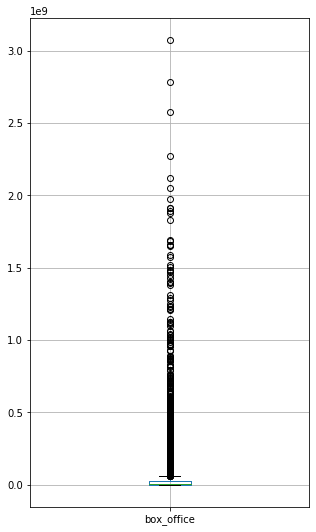

In [49]:
# Метод describe() покажет нам основные параметры в цифрах (среднее, свартили и отклонения)
display(df['box_office'].describe())

# Ящик с усами покажет "выбросы"
df[['box_office']].boxplot(figsize=(5,9))

Видим, что распределение далеко от нормального. Посмотрим различные срезы:

In [50]:
df['box_office'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.01               0.00
0.01             100.00
0.05             500.00
0.10           1,700.00
0.50       2,416,796.50
0.90     189,321,788.15
0.95     482,178,031.49
0.99   1,293,081,078.25
0.99   1,651,866,297.14
Name: box_office, dtype: float64

Посмотрим на распределение со сборами более 2000 и менее 500 000 000:

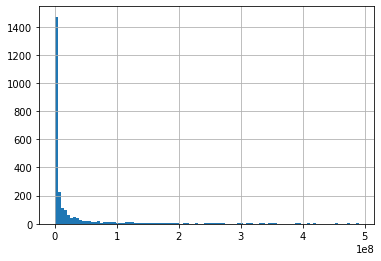

In [51]:
df.query('2000 < box_office < 500000000')['box_office'].hist(bins=100)

Распределение все еще далеко от нормального.
Посмотрим на список кассовых фильмов:

In [52]:
df.query('box_office > 1000000000')

,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,...,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genre,support_part
1960,1962,1981,Седьмой сын,121026614,2014-11-11 12:00:00+00:00,Художественный,"Леджендари Пикчерз, Мовинг Пикчерз Компани, Ут...","США, Великобритания, Канада, КНР",Сергей Бодров,"Бэзил Иваник, Томас Тулл, Лайонел Уигрэм",...,nan,nan,NaN,5.80,"фэнтези,приключения","1,016,410,635.30",2014,Сергей Бодров,фэнтези,nan
2081,2083,2104,Форсаж 7,121001215,2015-01-27 12:00:00+00:00,Художественный,"Юниверсал Пикчерз, Релятивити Медиа, Дентсу, Ф...",США,Джеймс Ван,"Вин Дизель, Майкл Фоттрел",...,nan,nan,NaN,7.00,"боевик,триллер,приключения","1,486,131,019.00",2015,Джеймс Ван,боевик,nan
2134,2136,2158,Мстители: Эра Альтрона,121007215,2015-04-03 12:00:00+00:00,Художественный,Марвел Студиос,США,Джосс Уидон,Кевин Фейги,...,nan,nan,NaN,7.20,"фантастика,боевик,приключения","1,500,989,281.90",2015,Джосс Уидон,фантастика,nan
2477,2479,2508,Терминатор: Генезис,121012415,2015-06-11 12:00:00+00:00,Художественный,"Парамаунт Пикчерз, Скайдэнс Продакшнз",США,Алан Тэйлор,"Дэвид Эллисон, Дэна Голдберг",...,nan,nan,NaN,6.40,"фантастика,боевик,триллер","1,060,054,283.00",2015,Алан Тэйлор,фантастика,nan
2479,2481,2510,Монстры на каникулах 2,124003615,2015-10-15 12:00:00+00:00,Анимационный,"Коламбиа Пикчерз, ЭлСтар Кэпитал, Сони Пикчерз...",США,Геннадий Тартаковский,"Аллен Коверт, Мишель Мердокка",...,nan,nan,NaN,7.20,"мультфильм,фэнтези,комедия","1,000,157,204.40",2015,Геннадий Тартаковский,мультфильм,nan
2542,2544,2577,Миньоны,124001715,2015-03-30 12:00:00+00:00,Анимационный,Иллюминейшн Интертейнмент,США,"Кайл Балда, Пьер Соффин","Кристофер Меледандри, Джанет Хили",...,nan,nan,NaN,6.20,"мультфильм,фантастика,комедия","1,646,580,645.70",2015,Кайл Балда,мультфильм,nan
2543,2545,2578,Мир Юрского периода,121006515,2015-04-03 12:00:00+00:00,Художественный,"Эмблин Интертейнмент, Леджендари Пикчерз, Юнив...",США,Колин Треворроу,"Патрик Краули, Фрэнк Маршалл",...,nan,nan,NaN,6.90,"фантастика,приключения,боевик","1,211,158,990.00",2015,Колин Треворроу,фантастика,nan
2796,2798,2839,Дэдпул,121002116,2016-02-03 12:00:00+00:00,Художественный,"ХХ век Фокс, Марвел Энтерпрайзиз, Тэ Эс Гэ Инт...","США, Канада",Тим Миллер,"Саймон Кинберг, Райан Рейнольдс, Лорен Шулер Д...",...,nan,nan,NaN,7.50,"фантастика,боевик,комедия","1,587,516,389.00",2016,Тим Миллер,фантастика,nan
2815,2817,2858,Зверополис,124000316,2016-02-15 12:00:00+00:00,Анимационный,"Уолт Дисней Анимейшн Студиос, Уолт Дисней Пикчерз",США,"Рич Мур, Байрон Ховард",Кларк Спенсер,...,nan,nan,NaN,8.30,"мультфильм,комедия,криминал","2,048,126,108.00",2016,Рич Мур,мультфильм,nan
2874,2876,2919,Экипаж,111005416,2016-03-21 12:00:00+00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,Н.Лебедев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",...,"392,104,482.00","635,283,867.00",Фонд кино,7.60,"драма,триллер,приключения","1,402,255,390.00",2016,Н.Лебедев,драма,0.70


Это действительно все очень популярные и рекламируемые в свое время фильмы, эти данные не являются ошибочными, просто так и есть - эти фильмы кассовые и в свое время действительно много собрали.

Можно изучить фильмы, не принесшие денег:

In [53]:
df.query('box_office < 3000')

,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,...,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genre,support_part
6,6,6,Любовь и голуби,111007013,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,Неизвестно,...,nan,nan,NaN,8.30,"мелодрама,комедия","2,700.00",2013,В.Меньшов,мелодрама,nan
18,18,18,Неподдающиеся,111003616,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Ю.Чулюкин,Неизвестно,...,nan,nan,NaN,8.00,"мелодрама,комедия",360.00,2016,Ю.Чулюкин,мелодрама,nan
19,19,19,Неподсуден,111003716,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"В.Краснопольский, В.Усков",Неизвестно,...,nan,nan,NaN,7.70,драма,420.00,2016,В.Краснопольский,драма,nan
22,22,22,"Операция ""Ы"" и другие приключения Шурика",111007413,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Л.Гайдай,Неизвестно,...,nan,nan,NaN,8.70,"комедия,мелодрама,криминал",380.00,2013,Л.Гайдай,комедия,nan
38,38,38,Мужики!,111007213,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,И.Бабич,Неизвестно,...,nan,nan,NaN,8.10,драма,"1,165.00",2013,И.Бабич,драма,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5196,5205,5281,Война богов: Бессмертные 3D,121020411,2011-10-25 12:00:00+00:00,Художественный,"Релативити Медиа, Этмосфиэ Интертейнмент ЭмЭм,...",США,Тарсем Синх,"Марк Кэнтон, Райан Кавано, Джанни Нуннари",...,nan,nan,NaN,5.80,"фэнтези,боевик,драма","1,710.00",2011,Тарсем Синх,фэнтези,nan
5211,5220,5296,Бой с тенью-3: последний раунд,111007211,2011-10-18 12:00:00+00:00,Художественный,"ООО ""Шаман пикчерс""",Россия,А.Сидоров,Неизвестно,...,nan,nan,NaN,6.30,"боевик,драма,криминал",500.00,2011,А.Сидоров,боевик,nan
5256,5265,5342,Хранитель времени 3D,121023411,2011-12-15 12:00:00+00:00,Художественный,"ДжиКей Филмз, Инфинитум Найхл",США,Мартин Скорсезе,"Джонни Депп, Тим Хэдингтон, Грэм Кинг, Мартин ...",...,nan,nan,NaN,6.90,"драма,детектив,приключения",750.00,2011,Мартин Скорсезе,драма,nan
5273,5282,5359,Резня /По пьесе Ясмины Резы/,121022511,2011-11-29 12:00:00+00:00,Художественный,"Эс Би Эс Продакшнз, Константин Филм, Эс Пи Ай ...","Германия, Франция, Польша",Роман Полански,"Оливер Бербен, Мартин Московиц, Саид Бен Саид",...,nan,nan,NaN,7.40,"драма,комедия","2,000.00",2011,Роман Полански,драма,nan


Эти фильмы вызывают куда больше вопросов. Посмотрим подробнее срезы:

In [54]:
df['box_office'].quantile([0.005,.01,.05,.1,.15,.2,.22,.25])

0.01        0.00
0.01      100.00
0.05      500.00
0.10    1,700.00
0.15    5,571.25
0.20   18,600.00
0.22   35,871.00
0.25   80,108.75
Name: box_office, dtype: float64

Конечно, не хочется убирать 15% данных, но мне они кажутся ошибочными. В этом списке, пусть и не самые кассовые фильмы, но они были на слуху:

In [55]:
inform_func(df.query('box_office < 3000')[['title', 'show_start_date', 'box_office', 'year']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 6 to 5301
Data columns (total 4 columns):
title              381 non-null object
show_start_date    381 non-null datetime64[ns, UTC]
box_office         381 non-null float64
year               381 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 14.9+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
title,381,378,Большая афера,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_start_date,381,272,2013-10-18 12:00:00+00:00,14,2010-01-19 12:00:00+00:00,2016-12-22 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
box_office,381.00,NaN,NaN,NaN,NaT,NaT,934.72,780.05,0.00,300.00,700.00,"1,530.00","2,905.00"
year,381.00,7.00,"2,014.00",88.00,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,title,show_start_date,box_office,year
504,Эмили Жоли,2012-04-25 12:00:00+00:00,240.00,2012
1754,Весёлые ребята ;),2014-02-27 12:00:00+00:00,0.00,2014
96,Дамы приглашают кавалеров,2014-10-01 12:00:00+00:00,"2,260.00",2014
2090,Мертвые души,2014-12-24 12:00:00+00:00,500.00,2014
1631,Железяки,2013-06-11 12:00:00+00:00,150.00,2013


Такие фильмы как "Резня" Полански, "Хранитель времени" точно собрали больше, чем 2000. При чем прокат указан, судя по всему, в рублях (для кассовых - вероятнее всего рубли). Но вот по поводу валюты - вопрос. Здесь тоже лучше бы уточнить валюту, так как о ней точной информации нет. 

В общем, я считаю эти данные ошибочными. Даже для повторных прокатов совестких фильмов такие сборы маловероятны. Чтобы уж совсем не убирать 25% оставлю рубеж 50000:

In [56]:
df_lim = df.query('box_office > 50000')
df_lim.shape

(2365, 22)

## Исследовательская часть <a id='research'></a>

Посмотрим, сколько фильмов выходило в прокат каждый годи посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.<a id='count_film'></a>

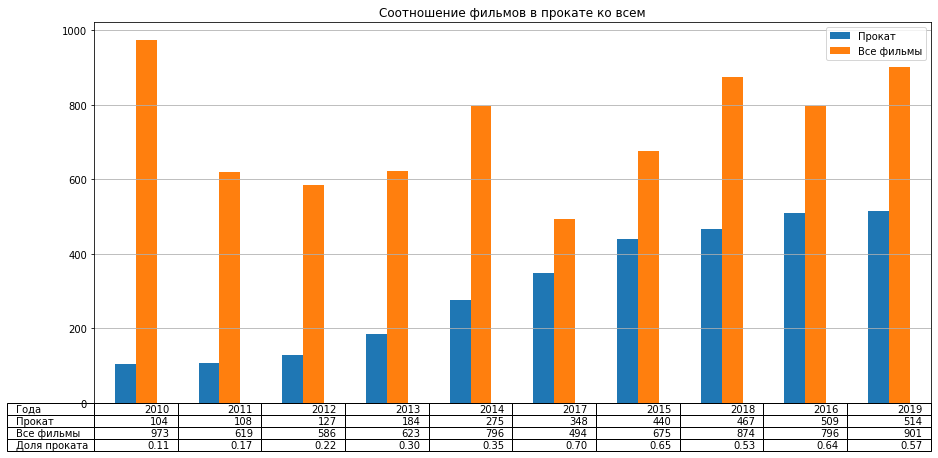

In [57]:
# Сначала сделаем таблицу, где сведм информацию обо всех фильмах и 
# подтянем к ней информацию о количестве фильмов в прокате:

df_by_year = (
    df[df['box_office'].notna()].groupby('year')['puNumber'].count().sort_values().reset_index()
    .merge(
        df.groupby('year')['puNumber'].count().reset_index(), 
        on = 'year', how = 'left'
    )
)

# Переименуем колонки для удобства:
df_by_year.columns = ['year', 'box_office', 'all']
df_by_year['box_ratio'] = pd.Series(
    '{:.2f}'.format(x) for x in list(df_by_year['box_office'] / df_by_year['all'])
)

# Посмотрим, как различаются данные с помощью столбчатой диаграммы
# На одном поле выведем количество всех фильмов и фильмов в прокате по годам:
df_by_year.plot(x='year', kind = 'bar', grid=True, figsize=(15,7), label=False)
plt.legend(['Прокат', 'Все фильмы'])
plt.xticks([])
plt.xlabel('')
plt.title('Соотношение фильмов в прокате ко всем')

# Для наглядности добавим таблицу с данными:
plt.table(cellText=[list(x) for x in df_by_year.values.T],
          rowLabels=['Года','Прокат','Все фильмы', 'Доля проката']
         ).auto_set_font_size()
plt.show()

Разница заментая особенно для 2010 года, когда из 973 фильмов данные о прокате есть только для 104. Наименьшая разница у 2017 года.
Но здесь информация собрана с данными о прокате, которые мы не обрабатывали.

Посмотрим, какую долю занимают фильмы с данными о прокате от общего числа фильмов:

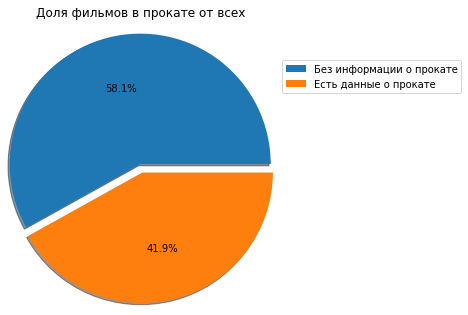

In [58]:
# Для долей хорошо подходит круговая диаграмма:

plt.pie([(df_by_year['all'].sum() - df_by_year['box_office'].sum()), df_by_year['box_office'].sum()],
        autopct='%1.1f%%', 
        radius=1.5, 
        explode=(0, .1), 
        shadow=True
       )
plt.legend(loc = 'best', 
           bbox_to_anchor=(1.5, 0.5, 0.5, 0.5), 
           labels = ['Без информации о прокате', 'Есть данные о прокате'])
plt.title('Доля фильмов в прокате от всех', y=1.15)
plt.show()

Доля фильмов с данными о прокате составляет 41,9%. Посмотрим, как сильно изменилась доля после удаления слишком маленьких сборов:

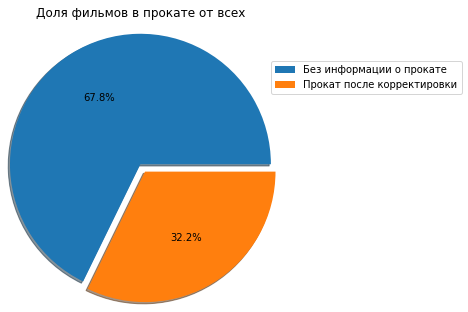

In [59]:
plt.pie([(df.shape[0] - df_lim.shape[0]), df_lim.shape[0]],
        autopct='%1.1f%%', 
        radius=1.5, 
        explode=(0, .1), 
        shadow=True
       )
plt.legend(loc = 'best', 
           bbox_to_anchor=(1.5, 0.5, 0.5, 0.5), 
           labels = ['Без информации о прокате', 'Прокат после корректировки'])
plt.title('Доля фильмов в прокате от всех', y=1.15)
plt.show()

Так как мной было удалено довольно много данных, процент снизился до 32,2%.

В целом, можно сделать вывод, что доля фильмов в прокате от общего числа выпускаемых фильмов от года в год разная, но до 2015 года стабильно не превышала 35%, а в 2015% резко возрасла, достигнув максимума (70%) в 2017 году (стоит заметить, что 2017 году вышло наименьшее число фильмов), и затем снова немного снизилась, однако все равно превышала 50%.

Изучим, как менялись сборы по годам: динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?<a id='dynamic'></a>

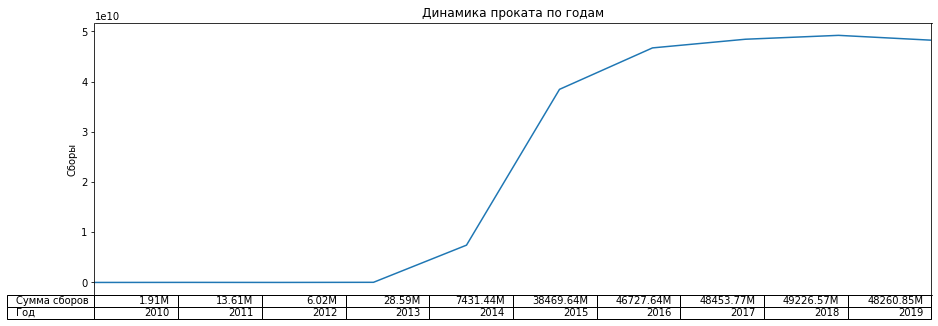

Год с максимальной суммой сборов:  2018 
 Сумма сборов:  49226572210.63
Год с минимальной суммой сборов:  2010 
 Сумма сборов:  1914501.0


In [60]:
# Построим линейный график:
df_lim.groupby('year')['box_office'].sum().plot(kind='line', figsize=(15,5))
plt.title('Динамика проката по годам')
plt.ylabel('Сборы')
plt.xlabel('')
plt.xticks([])
plt.table(cellText=[['{:1.2f}M'.format(x*1e-6) for x in df_lim.groupby('year')['box_office'].sum()],
                    [x for x in df_lim.groupby('year')['box_office'].sum().index]
                   ], rowLabels=['Сумма сборов','Год']
).auto_set_font_size()
#plt.table.set_fontsize(5)
plt.show()

print('Год с максимальной суммой сборов: ', 
      df_lim.groupby('year')['box_office'].sum().idxmax(), '\n',
     'Сумма сборов: ', 
      '{:.2f}'.format(df_lim.groupby('year')['box_office'].sum().reset_index().max()['box_office']))
print('Год с минимальной суммой сборов: ', 
      df_lim.groupby('year')['box_office'].sum().idxmin(), '\n',
     'Сумма сборов: ', df_lim.groupby('year')['box_office'].sum().reset_index().min()['box_office'])

#df_lim.groupby('year')['box_office'].sum()

Мы видим, что до 2013 года сборы были настолько малы, что не являются чувствительными для графика. Возможно, это тоже какие-то ошибочные данные (связанные с тем, например, что данные о сборах указаны в долларах для этих лет), так как с 2015 года виден резкий скачок вверх, и с тех пор величина сборов только растет, немного совсем наметив динамику на спад в 2019году.

С помощью сводной таблицы посчитаем среднюю и медианную сумму сборов для каждого года.

In [61]:
df_lim.pivot_table(index='year', values='box_office', aggfunc=['mean','median'])


,mean,median
,box_office,box_office
year,,
2010,"478,625.25","207,020.50"
2011,"1,046,567.85","73,416.00"
2012,"354,277.59","103,210.00"
2013,"1,429,471.31","142,907.75"
2014,"60,913,480.78","838,900.50"
2015,"95,934,271.83","9,200,824.50"
2016,"99,845,391.99","5,686,963.27"
2017,"139,636,220.19","10,598,124.00"


Видим большую разницу между средней и медианой, обусловленную большой разницой в сборах между кассовыми фильмами и теми, которые не собрали в прокате больших денег.

Определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? <a id='age'></a>

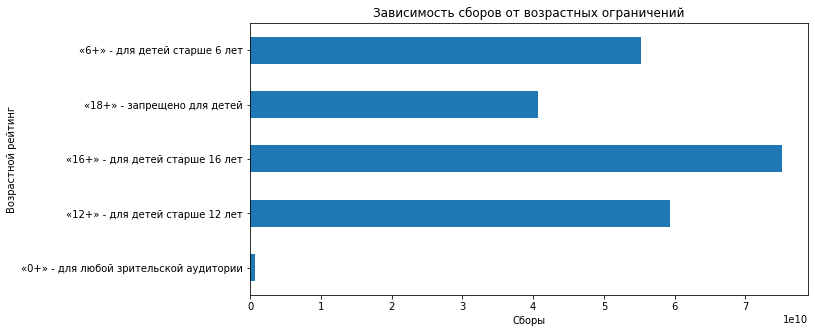

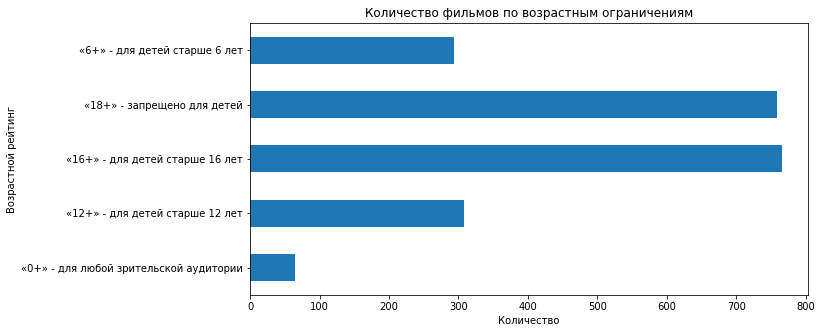

In [62]:
# Строим столбчатую диаграмму для сборов
(
    df_lim[df_lim['year'] >= 2015].groupby('age_restriction')['box_office'].sum()
    .plot(kind='barh', figsize=(10,5))
)
plt.title('Зависимость сборов от возрастных ограничений')
plt.ylabel('Возрастной рейтинг')
plt.xlabel('Сборы')
plt.show()

# И построим столбчатую диаграмму для количества фильмов в прокате:
(
    df_lim[df_lim['year'] >= 2015].groupby('age_restriction')['box_office'].count()
    .plot(kind='barh', figsize=(10,5))
)
plt.title('Количество фильмов по возрастным ограничениям')
plt.ylabel('Возрастной рейтинг')
plt.xlabel('Количество')
plt.show()

Фильмы, ориентированные на детскую аудиторию (0+) собрали маленькую кассу, но и выходило их наименьшее число. Интереснее с категориями 6+ и 12+ - их выходило примерно одинакого не много, но при этом по кассовым сборам они делят 2 и 3 места, это связано с тем, что на такие фильмы дети ходят как правило с родителями, поэтому билетов в среднем покупается больше на каждый сеанс.

Больше всего выходит фильмов 16+ и 18+, при этом наименьший доход у фильмов, ориентированных только на взрослую аудиторию. Выпускать фильм с рейтингом 18+ довольно рискованно, поэтому многие студии намеренно снижают рейтинг до хотя бы 16+, чтобы окупиться в прокате с большей вероятностью.

Теперь изучим фильмы с государственным финансированием. <a id='support'></a>

In [63]:
df_supp = df_lim[df_lim['refundable_support'].notna()]
inform_func(df_supp)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 1272 to 7335
Data columns (total 22 columns):
level_0                  292 non-null int64
index                    292 non-null int64
title                    292 non-null object
puNumber                 292 non-null int64
show_start_date          292 non-null datetime64[ns, UTC]
type                     292 non-null object
film_studio              292 non-null object
production_country       292 non-null object
director                 292 non-null object
producer                 292 non-null object
age_restriction          292 non-null object
refundable_support       292 non-null float64
nonrefundable_support    292 non-null float64
budget                   292 non-null float64
financing_source         292 non-null object
ratings                  292 non-null float64
genres                   292 non-null object
box_office               292 non-null float64
year                     292 non-null object
main_director        

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
level_0,292.00,NaN,NaN,NaN,NaT,NaT,"4,370.39","1,808.52","1,273.00","2,768.25","3,557.50","6,063.25","7,344.00"
index,292.00,NaN,NaN,NaN,NaT,NaT,"4,435.73","1,836.25","1,281.00","2,807.75","3,621.50","6,146.25","7,465.00"
title,292,292,Кислота,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
puNumber,292.00,NaN,NaN,NaN,NaT,NaT,"111,255,958.82","823,563.53","111,000,115.00","111,004,815.75","111,009,965.50","111,016,690.75","114,010,018.00"
show_start_date,292,255,2018-06-07 12:00:00+00:00,4,2013-09-10 12:00:00+00:00,2019-12-26 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,292,2,Художественный,268,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
film_studio,292,235,"ООО ""Студия анимационного кино ""Мельница""",7,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_country,292,13,Россия,278,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,292,254,Д.Дьяченко,4,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
producer,292,243,С.Сельянов,8,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,level_0,index,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,...,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genre,support_part
7194,7203,7319,Новогодний ремонт,111018219,2019-11-07 12:00:00+00:00,Художественный,"ООО ""ВитЭл""",Россия,А.Пинхасов,"Е.Михайлова, В.Галыгин, В.Колесник, А.Седых, Г...",...,"20,000,000.00","30,448,911.00",Министерство культуры,5.60,"комедия,мелодрама","3,591,456.36",2019,А.Пинхасов,комедия,0.66
3710,3712,3781,Мотылёк,111001617,2017-03-22 12:00:00+00:00,Художественный,"ООО ""Кинокомпания КИТ""",Россия,К.Худяков,"Е.Бабенко, В.Ремизов",...,"30,000,000.00","63,170,000.00","Министерство культуры, Фонд кино",8.00,драма,"410,058.00",2017,К.Худяков,драма,0.59
7088,7097,7208,Дикая Лига (авторская версия),111014819,2019-09-19 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ""Новое Время"", ООО ""Му...",Россия,"А.Богатырев, А.Камачо","О.Ледяева, Ю.Перкуль, А.Леонтьев, И.Добровольский",...,"50,000,000.00","147,866,278.00",Министерство культуры,6.20,Неизвестно,"3,402,053.55",2019,А.Богатырев,Неизвестно,0.34
5549,5558,5638,Девушка с косой,111011517,2017-12-14 12:00:00+00:00,Художественный,"ООО Кинокомпания ""100фильм""",Россия,О.Попова,"В.Брумберг, В.Сторожева",...,"25,000,000.00","38,000,000.00",Министерство культуры,5.80,комедия,"2,671,050.00",2017,О.Попова,комедия,0.66
2117,2119,2141,Территория,111000515,2015-01-27 12:00:00+00:00,Художественный,"ООО ""Творческое объединение ""Кинокомпания ""Анд...",Россия,А.Мельник,А.Мельник,...,"30,000,000.00","500,000,000.00",Фонд кино,6.80,"детектив,фэнтези,триллер","72,578,317.40",2015,А.Мельник,детектив,0.12


In [64]:
df_pt_supp_mn = (
    df_supp.groupby(['financing_source', 'year'])
    ['refundable_support', 'nonrefundable_support', 'budget', 'box_office'].mean()
    .reset_index()
)
df_pt_supp_md = (
    df_supp.groupby(['financing_source', 'year'])
    ['refundable_support', 'nonrefundable_support', 'budget', 'box_office'].median()
    .reset_index()
)

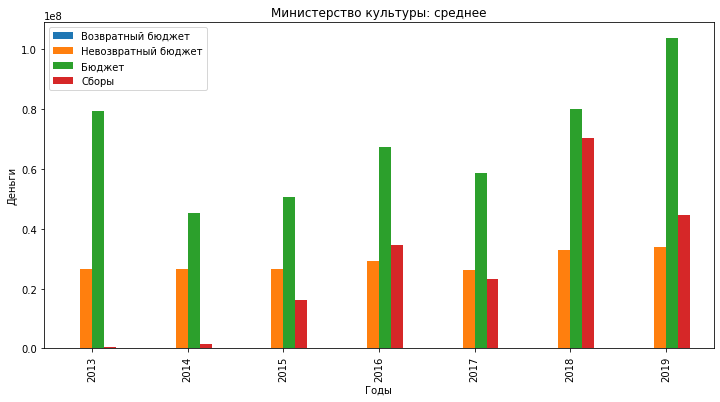

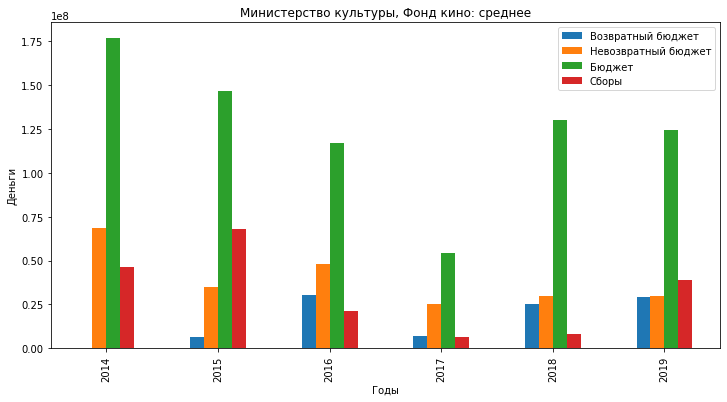

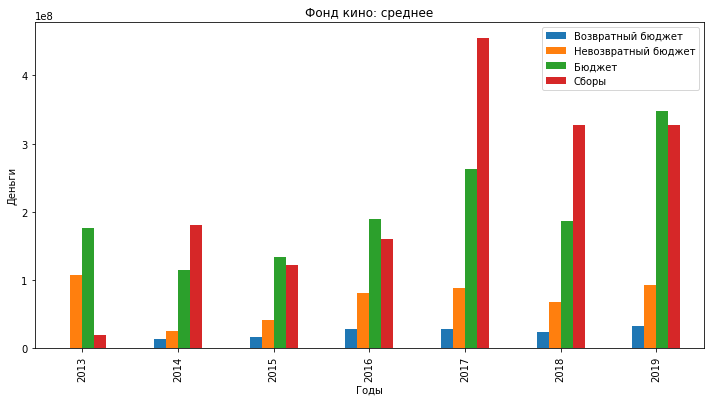

In [65]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    (
        df_pt_supp_mn[df_pt_supp_mn['financing_source'] == financing_source]
        .plot(x='year', kind='bar', figsize=(12,6))
    )
    plt.legend(['Возвратный бюджет', 'Невозвратный бюджет', 'Бюджет', 'Сборы'])
    plt.title(f'{financing_source}: cреднее')
    plt.xlabel('Годы')
    plt.ylabel('Деньги')

Исходя из графиков, построенных по средним показателям, можно сделать следующее утверждение:
- Министерство Культуры: они спонсируют фильмы только невозвратными денежными средствами и их проектные в среднем не окупаются по годам вообще. Наиболее удачным можно назвать 2018 год, когда сборы практически сравнялись с бюджетом. Единственное, можно заметить небольшую положительную динамику, возможно, в будущем вероятен прогресс.
- Соместные проекты Министерства Культуры и Фонда Кино с реднем еще менее успешны, но с годами увеличивается возвратная часть, однако сборы часто не превышают даже ее уровень. По средним показателям именно их проекты являются самыми убыточными.
- Фонд кино: именно их можно назвать наиболее эффективными среди прочих. Был весьма успешный 2017 год, хороший 2018 и 2014, когда сборы в среднем превышали бюджет. Данные показатели лучше, чем у остальных, но совершенно не факт, что проекты принесли именно прибыль, а не только окупили себя.

Посмотрим по медиане -  так как разница может оказаться существенной из-за присутствующих в средних расчетах неких особо убыточных или особо прибыльных проектов:

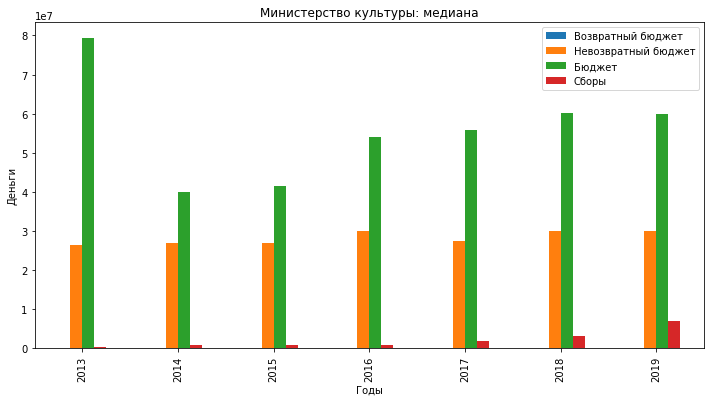

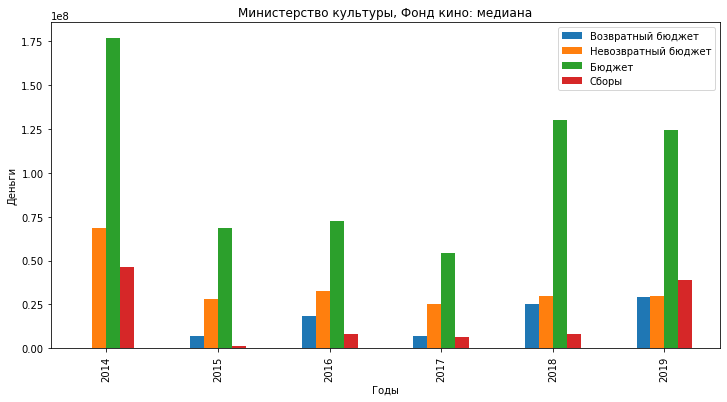

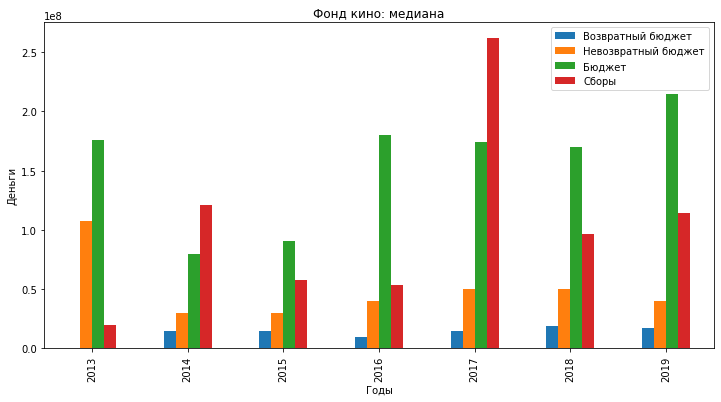

In [66]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    (
        df_pt_supp_md[df_pt_supp_md['financing_source'] == financing_source]
        .plot(x='year', kind='bar', figsize=(12,6))
    )
    plt.legend(['Возвратный бюджет', 'Невозвратный бюджет', 'Бюджет', 'Сборы'])
    plt.title(f'{financing_source}: медиана')
    plt.xlabel('Годы')
    plt.ylabel('Деньги')

Картина несколько поменялась:
- Министерство Культуры: у них явно не стабильная ситуация. Есть какие-то вполне успешные проекты, они сильно влияют на среднее, а медиана при это очень мала - огромная разница между сборами и бюджетом, далеко не в пользу сборов.
- Соместные проекты Министерства Культуры и Фонда Кино картина почти не изменилась за исключением 2015 года, когда среднее повысил какой-то успешный проект.
- Фонд кино: 2017 и 2014 год остался единственным, когда сборы превысили бюджет. в 2018 и в 2019 у них тоже были какие-то удачные проекты, повысившие среднее в эти года.

Поищем самые успешные и самые неудачные проекты с точки зрения финансирования.

In [67]:
df_raiting = df_supp.pivot_table(index=['financing_source', 'title', 'year', 'ratings'],
                    values=['refundable_support', 'nonrefundable_support', 'budget', 'box_office', 'support_part'],
                    aggfunc='sum'
                   ).reset_index()
df_raiting

,financing_source,title,year,ratings,box_office,budget,nonrefundable_support,refundable_support,support_part
0,Министерство культуры,28 Панфиловцев,2016,7.50,"363,622,804.90","85,384,000.00","30,000,000.00",0.00,0.35
1,Министерство культуры,No comment (Нет комментариев),2015,6.20,"250,508.00","40,287,770.00","28,000,000.00",0.00,0.69
2,Министерство культуры,Pro любовь,2015,6.60,"52,882,302.12","55,195,000.00","20,000,000.00",0.00,0.36
3,Министерство культуры,Айка,2019,6.20,"2,446,886.00","108,518,988.00","28,000,000.00",0.00,0.26
4,Министерство культуры,Ангелы Революции,2014,6.40,"869,181.00","40,000,000.00","28,000,000.00",0.00,0.70
...,...,...,...,...,...,...,...,...,...
287,Фонд кино,Черновик,2018,4.90,"204,158,417.05","200,067,392.00","100,000,000.00","40,000,000.00",0.70
288,Фонд кино,Чистое искусство,2015,5.90,"6,457,303.02","111,736,163.00","60,000,000.00","15,000,000.00",0.67
289,Фонд кино,Экипаж,2016,7.60,"1,402,255,390.00","635,283,867.00","392,104,482.00","50,000,000.00",0.70
290,Фонд кино,Эластико,2016,6.30,"19,393,384.34","30,000,000.00","15,000,000.00",0.00,0.50


In [68]:
y=df_raiting['support_part'].values
y_format = []
for i in y:
    y_format.append('{:.2f}'.format(i))
#print(y_format)

df_raiting['support_part'] = pd.Series(y_format)

# Колонка, показывающая во сколько раз фильм окупился в прокате:
df_raiting['payback_lvl'] = df_raiting['box_office'] / df_raiting['budget']

In [69]:
(
    df_raiting[df_raiting['financing_source'] == 'Министерство культуры']
        .groupby(['title', 'year', 'support_part'])[['budget', 'box_office', 'payback_lvl']].sum()
        .sort_values(by='payback_lvl', ascending=False).head(5)
)

,,,budget,box_office,payback_lvl
title,year,support_part,,,
Я худею,2018,0.34,"87,649,127.00","633,462,266.74",7.23
"Гуляй, Вася !",2016,0.65,"39,000,000.00","259,099,078.00",6.64
Непрощенный,2018,0.48,"82,496,889.00","393,279,629.43",4.77
Бабушка лёгкого поведения 2,2019,0.39,"101,463,696.00","439,776,371.25",4.33
28 Панфиловцев,2016,0.35,"85,384,000.00","363,622,804.90",4.26


Министерство культуры: топ-10 прибыльных проектов


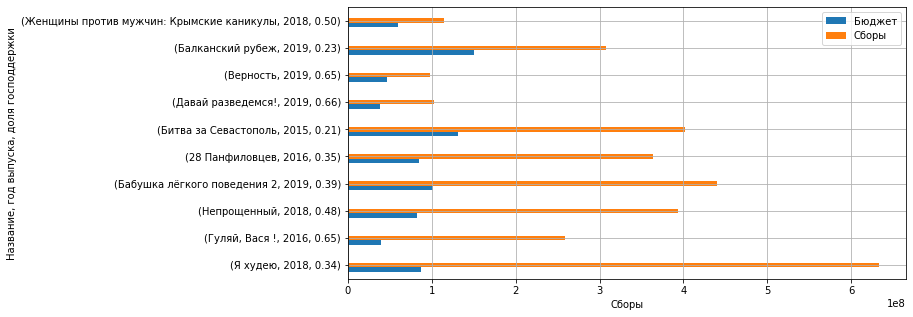

Министерство культуры, Фонд кино: топ-10 прибыльных проектов


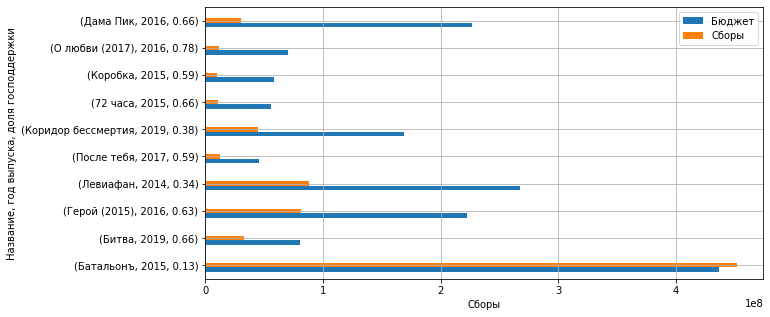

Фонд кино: топ-10 прибыльных проектов


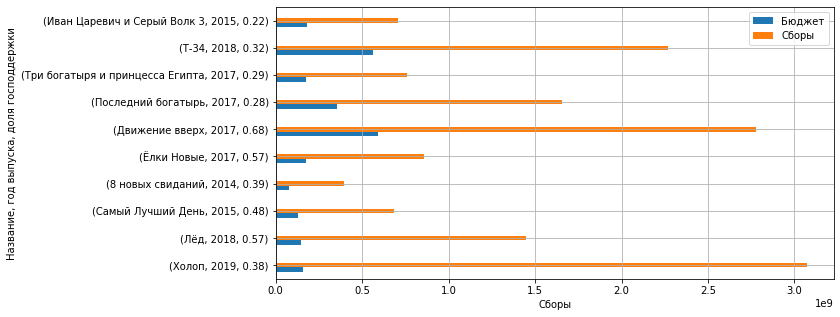

In [70]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    print(f'{financing_source}: топ-10 прибыльных проектов')
    fig, ax = plt.subplots()
    
    (
        df_raiting[df_raiting['financing_source'] == financing_source]
        .groupby(['title', 'year', 'support_part'])[['budget', 'box_office', 'payback_lvl']].sum()
        .sort_values(by='payback_lvl', ascending=False).head(10)
        .plot(kind='barh', grid=True, figsize=(10,5), ax=ax)
    )
    plt.legend(['Бюджет', 'Сборы'])
    plt.xlabel('Сборы')
    plt.ylabel('Название, год выпуска, доля господдержки')
    plt.show()
    

Судя по топу удачных проектом, у Министерства Культуры есть примеры весьма удачного финансирования: фильм "Я худею" принес очень хорошую прибыть и еще ряд успешных проектов. Так же у Фонда Кино есть очень успешный "Холоп". А вот совместные проекты Фонда Кино и Мин. Культуры не приносят прибыли вообще. Их самый кассовый фильм еле превысил по сборам бюджет. 

Оценим неудачные проекты:

Министерство культуры: топ-10 неудачных проектов


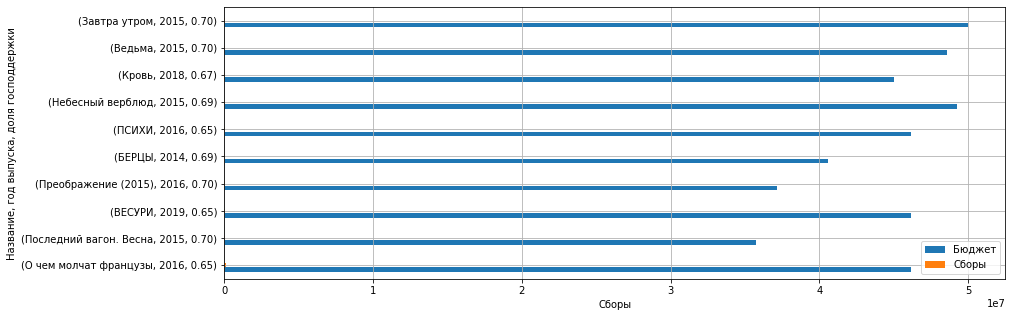

Министерство культуры, Фонд кино: топ-10 неудачных проектов


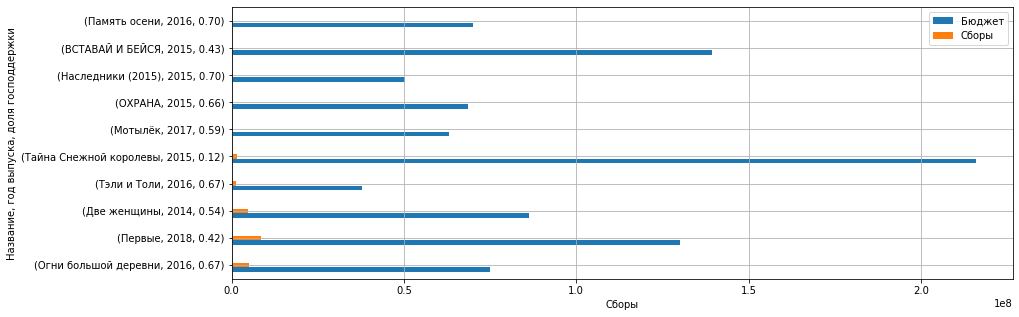

Фонд кино: топ-10 неудачных проектов


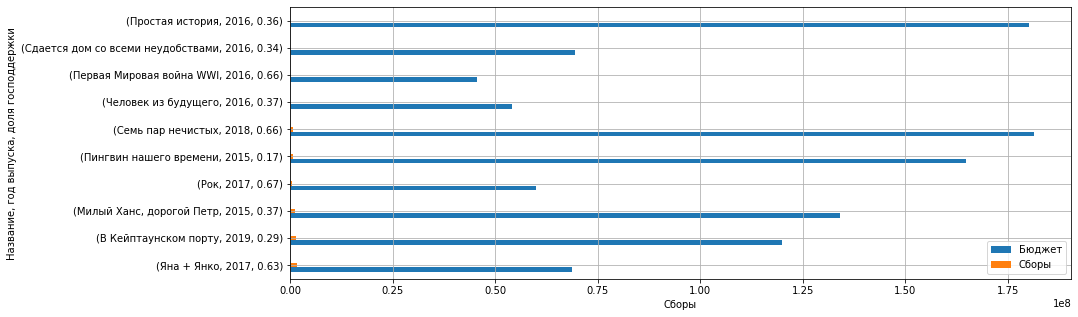

In [71]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    print(f'{financing_source}: топ-10 неудачных проектов')
    (
        df_raiting[df_raiting['financing_source'] == financing_source]
        .groupby(['title', 'year', 'support_part'])[['budget', 'box_office', 'payback_lvl']].sum()
        .sort_values(by='payback_lvl', ascending=False).tail(10)
        .plot(kind='barh', grid=True, figsize=(14,5))
    )
    plt.xlabel('Сборы')
    plt.ylabel('Название, год выпуска, доля господдержки')
    plt.legend(['Бюджет', 'Сборы'])
    plt.show()

Можно заметить, что доля участия в неудачных проектах почти всегда 60-70%. Фонд Кино в неудачных участвут меньшей долей, чем остальные (2016 год был для них не самым удачным). При этом разница между общим бюджетом и сборами настолько велика, что сборы не отображаются на графике ввиду их малозначительности по сравнению с бюджетом. При этом мы можем оценить дороговизну проектов - фильмы нельзя назвать совсем уж малобюджетными. 

Можно оценить в целом число проектов, сборы которых хотя бы покрывают бюджет:

In [72]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    
    payback_ok = (
        df_raiting[(df_raiting['financing_source'] == financing_source) & 
                   (df_raiting['payback_lvl'] >= 1)]['title'].count()
    )
    payback_nok = (
        df_raiting[(df_raiting['financing_source'] == financing_source) & 
                   (df_raiting['payback_lvl'] < 1)]['title'].count()
    )
    print(f'Количество фильмов, где сборы больше или равны бюджету: {financing_source} - {payback_ok}')
    print(f'Количество фильмов, провалившихся в прокате: {financing_source} - {payback_nok}')

Количество фильмов, где сборы больше или равны бюджету: Министерство культуры - 16
Количество фильмов, провалившихся в прокате: Министерство культуры - 128
Количество фильмов, где сборы больше или равны бюджету: Министерство культуры, Фонд кино - 1
Количество фильмов, провалившихся в прокате: Министерство культуры, Фонд кино - 19
Количество фильмов, где сборы больше или равны бюджету: Фонд кино - 49
Количество фильмов, провалившихся в прокате: Фонд кино - 79


Не самая радужная картина: большинство проектов являются провальным. Особенно, если учитывать, что кинокартинка считается принесшей прибыль, если она окупилась в 2 раза. 

In [73]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    
    payback_ok = (
        df_raiting[(df_raiting['financing_source'] == financing_source) & 
                   (df_raiting['payback_lvl'] >= 2)]['title'].count()
    )
    count = df_raiting[df_raiting['financing_source'] == financing_source]['title'].count()
    print(f'Количество окупившихся фильмов: {financing_source} - {payback_ok} из {count}')
    

Количество окупившихся фильмов: Министерство культуры - 9 из 144
Количество окупившихся фильмов: Министерство культуры, Фонд кино - 0 из 20
Количество окупившихся фильмов: Фонд кино - 23 из 128


Получается, что окупаемость проектов Фонда Кино наибольшая, но и та составляет около 18%.

Изучим рейтинги фильмов по годам. Так как распределение данных в рейтинге было похоже на нормальное, можем использовать среднее:

Министерство культуры: рейтинги по годам


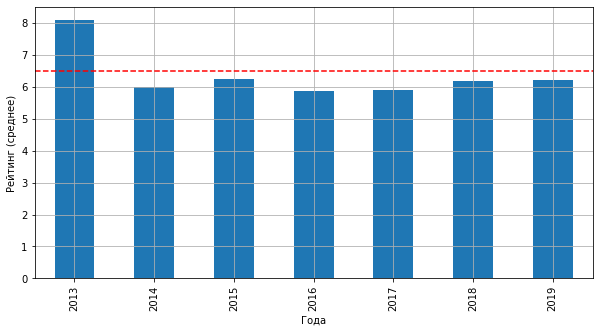

Министерство культуры, Фонд кино: рейтинги по годам


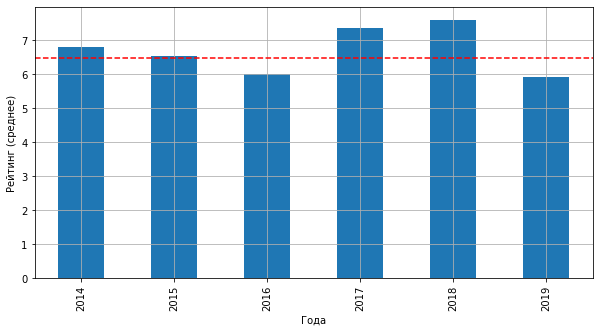

Фонд кино: рейтинги по годам


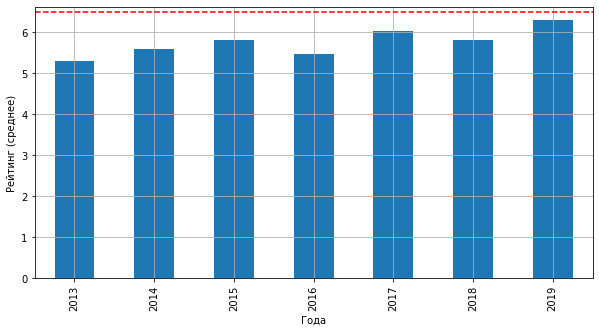

In [74]:
for financing_source in ['Министерство культуры', 
                         'Министерство культуры, Фонд кино',
                         'Фонд кино'
                        ]:
    print(f'{financing_source}: рейтинги по годам')
    (
        df_raiting[df_raiting['financing_source'] == financing_source]
        .groupby('year').agg({'ratings': 'mean'})
        .plot(kind='bar', grid=True, figsize=(10,5), legend=False)
    )
    plt.xlabel('Года')
    plt.ylabel('Рейтинг (среднее)')
    # проведем линию, обозначающую средний рейтинг по изначальной выборке:
    plt.axhline(y=df['ratings'].mean(), color='red', linestyle='--')
    plt.show()

Судя по рейтингам, Фонд Кино, не смотря на коммерчески более успешные фильмы, обладает наименьшим уровнем оценки своих произведений. В то время как плохо окупающиеся проекты Министерство Культуры и Фонда Кино имеют рейтинг в среднем выше. У Министерства Культуры есть странный пик в 2013 году, в остальном рейтинг проектов стабильно ниже немного среднего (6,6). Из этого можно сделать вывод, что некоторым неплохим проектам может не хватать огласки и(или) рекламы, а Фонд Кино умеет представить свои фильмы с коммерческой точки зрения, с точки зрения бизнеса.

## Общие выводы: <a id='conclus'></a>

- [Количество фильмов](#count_film), выходящий в прокат каждый год разная, но до 2015 года стабильно не превышала 35%, а в 2015% резко возрасла, достигнув максимума (70%) в 2017 году (стоит заметить, что 2017 году вышло наименьшее число фильмов), и затем снова немного снизилась, однако все равно превышала 50%. При этом можно все же выделить динамику на увеличение доли фильмов в прокате с течением времени.
- [Динамика проката](#dynamic) по годам показала немного необычную картину, когда в 2015 году возник резкий рост величины сборов. Возможно с данными по сборам за 2010-2014 года что-то не так. Если говорить о динамике 2015-2019 годов, то можно отметить более или менее ровную картинку по сборам со слегка наметившимся падением в 2019 году. Таким образом максимальная величина сборов пришлась на 2018 год, минимальная - на 2010 год.
- [Возрастное ограничение аудитории](#age) оказывает следующее влияние: (6+) и (12+) собирают хорошую кассу при небольшом количестве самих фильмов такой категории. Скорее всего это связано с тем, что на такие фильмы ходят и дети и их родители (то есть часто покупают сразу по 3-4 билета), а вот фильмы (18+) являются самыми рисковыми в плане недобора в прокате.
- Исследование фильмов, [получивших господдержку](#support), привело нас к заключению, что большая часть таких проектов не окупается. При среди очень плохо окупившихся кинолент есть весьма дорогие картины. Наиболее провальными были картины, поддерживаемые сразу и Министерством Культуры и Фондом Кино. Наиболее удачные проекты выпускает Фонд Кино, но все равно процент успешных картин не превышает 18%. При этом стоит отметить, что у Министерства Культуры отсутствует возвратная часть денег. Что же касается рейтингов, то в среднем проекты Фонда Кино оцениваются ниже среднего (при этом помним, что они чаще окупаются), а вот проекты Министерства Культуры совместно с Фондом Кино оцениваются часто выше среднего, но при этом не окупаются. Нам это говорит о том, что качество самого фильма не всегда влияет на сборы, часто решает грамотное продвижение и маркетинг.
